## 1. Libraries 📖

In [10]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import json 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [11]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [12]:
df_train = pd.read_csv("../../data/train/caco/caco_pubchem_train.csv")
df_test = pd.read_csv("../../data/train/caco/caco_pubchem_test.csv")
df_valid = pd.read_csv("../../data/train/caco/caco_pubchem_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [13]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'permeability']
y_train_all = df_train_all['permeability']

X_train = df_train.loc[:, df_train.columns != 'permeability']
y_train = df_train['permeability']

X_test = df_test.loc[:, df_test.columns != 'permeability']
y_test = df_test['permeability']

X_valid = df_valid.loc[:, df_valid.columns != 'permeability']
y_valid = df_valid['permeability']

In [14]:
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train_all = X_train_all[idxs['caco']]
X_train = X_train[idxs['caco']]
X_test = X_test[idxs['caco']]
X_valid = X_valid[idxs['caco']]

In [15]:
X_train.shape

(2460, 487)

In [16]:
X_test.shape

(704, 487)

In [17]:
X_valid.shape

(351, 487)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [21]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(487, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [22]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [23]:
best_value = 1000
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=351, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 875.6043182967545, Accuracy: -0.1380368274799862
Test Avg. loss: 804.20361328125, Accuracy: 0.13003911851126604
################## EPOCH 2 ##################
Train Avg. loss: 809.2230675437233, Accuracy: -0.0963021949079325
Test Avg. loss: 753.3086547851562, Accuracy: 0.1850954410521557
################## EPOCH 3 ##################
Train Avg. loss: 689.9473857136516, Accuracy: -0.0408739411995392
Test Avg. loss: 708.5109252929688, Accuracy: 0.23355623347277665
################## EPOCH 4 ##################
Train Avg. loss: 735.9695006531555, Accuracy: -0.17456404641124168
Test Avg. loss: 726.5938720703125, Accuracy: 0.2139947291198837
################## EPOCH 5 ##################
Train Avg. loss: 638.0309916904995, Accuracy: -0.01817240242144385
Test Avg. loss: 573.082275390625, Accuracy: 0.3800585400584472
################## EPOCH 6 ##################
Train Avg. loss: 637.6131410474901, Accura

Train Avg. loss: 338.6951023448597, Accuracy: 0.3518388918407438
Test Avg. loss: 334.889404296875, Accuracy: 0.6377277333039368
################## EPOCH 48 ##################
Train Avg. loss: 336.27647776417916, Accuracy: 0.3258046139844998
Test Avg. loss: 294.9483947753906, Accuracy: 0.6809345596292932
################## EPOCH 49 ##################
Train Avg. loss: 345.7690360329368, Accuracy: 0.3506546726806967
Test Avg. loss: 421.998291015625, Accuracy: 0.5434961870736947
################## EPOCH 50 ##################
Train Avg. loss: 318.9779230093027, Accuracy: 0.28923378598971494
Test Avg. loss: 312.1248779296875, Accuracy: 0.662353588472526
################## EPOCH 51 ##################
Train Avg. loss: 359.3541029892959, Accuracy: 0.28080919176961644
Test Avg. loss: 303.9075927734375, Accuracy: 0.6712427858085876
################## EPOCH 52 ##################
Train Avg. loss: 290.8069413915857, Accuracy: 0.40805949147571297
Test Avg. loss: 350.2780456542969, Accuracy: 0.6210807

Train Avg. loss: 260.093313638266, Accuracy: 0.4670806746113246
Test Avg. loss: 340.9260559082031, Accuracy: 0.6311974521473234
################## EPOCH 95 ##################
Train Avg. loss: 225.15755096039214, Accuracy: 0.5194695684141457
Test Avg. loss: 355.32470703125, Accuracy: 0.6156214488581269
################## EPOCH 96 ##################
Train Avg. loss: 275.5803400510317, Accuracy: 0.436547527411377
Test Avg. loss: 339.4561767578125, Accuracy: 0.6327875038944222
################## EPOCH 97 ##################
Train Avg. loss: 255.06884265255619, Accuracy: 0.5043057530488843
Test Avg. loss: 340.226806640625, Accuracy: 0.631953871068391
################## EPOCH 98 ##################
Train Avg. loss: 289.3637323751078, Accuracy: 0.43456789270147506
Test Avg. loss: 317.4815979003906, Accuracy: 0.6565589083552457
################## EPOCH 99 ##################
Train Avg. loss: 228.4967326374797, Accuracy: 0.5340492031296311
Test Avg. loss: 334.34820556640625, Accuracy: 0.6383131711

Train Avg. loss: 259.6640587348443, Accuracy: 0.48078790921027026
Test Avg. loss: 320.6066589355469, Accuracy: 0.6531783156793247
################## EPOCH 142 ##################
Train Avg. loss: 240.19697392451297, Accuracy: 0.5120887903738326
Test Avg. loss: 324.3975830078125, Accuracy: 0.6490774355651213
################## EPOCH 143 ##################
Train Avg. loss: 215.2322659182858, Accuracy: 0.5866449349544816
Test Avg. loss: 307.61700439453125, Accuracy: 0.667230077236225
################## EPOCH 144 ##################
Train Avg. loss: 253.4380047290356, Accuracy: 0.5304064418871031
Test Avg. loss: 325.52899169921875, Accuracy: 0.6478534804469114
################## EPOCH 145 ##################
Train Avg. loss: 213.856973573759, Accuracy: 0.5560912060990472
Test Avg. loss: 318.78253173828125, Accuracy: 0.6551515925940796
################## EPOCH 146 ##################
Train Avg. loss: 226.2275125082437, Accuracy: 0.5312194207412723
Test Avg. loss: 303.3252258300781, Accuracy: 0.

Train Avg. loss: 223.42849974198774, Accuracy: 0.6024125959679232
Test Avg. loss: 372.66363525390625, Accuracy: 0.5968647613138476
################## EPOCH 189 ##################
Train Avg. loss: 177.6039403444761, Accuracy: 0.5967688745850767
Test Avg. loss: 348.0122985839844, Accuracy: 0.62353181726942
################## EPOCH 190 ##################
Train Avg. loss: 191.63926954393264, Accuracy: 0.6066816068061818
Test Avg. loss: 375.5859680175781, Accuracy: 0.5937034958242007
################## EPOCH 191 ##################
Train Avg. loss: 170.73359541459516, Accuracy: 0.6326622031774779
Test Avg. loss: 351.349853515625, Accuracy: 0.6199213273709697
################## EPOCH 192 ##################
Train Avg. loss: 190.04856263197863, Accuracy: 0.5871264219003313
Test Avg. loss: 414.85113525390625, Accuracy: 0.5512277555016527
################## EPOCH 193 ##################
Train Avg. loss: 214.94654023802124, Accuracy: 0.5234330473679437
Test Avg. loss: 354.3440246582031, Accuracy: 0

Train Avg. loss: 195.9498922422335, Accuracy: 0.6214393965361584
Test Avg. loss: 312.65399169921875, Accuracy: 0.6617812614841343
################## EPOCH 236 ##################
Train Avg. loss: 170.25029764546977, Accuracy: 0.6195339516710094
Test Avg. loss: 329.5164489746094, Accuracy: 0.6435400081172026
################## EPOCH 237 ##################
Train Avg. loss: 178.44806230223023, Accuracy: 0.6332448057633954
Test Avg. loss: 348.3013610839844, Accuracy: 0.6232190306972518
################## EPOCH 238 ##################
Train Avg. loss: 165.1057848249163, Accuracy: 0.6421455424678123
Test Avg. loss: 364.9830017089844, Accuracy: 0.6051734684533822
################## EPOCH 239 ##################
Train Avg. loss: 241.15321959458387, Accuracy: 0.590219413086465
Test Avg. loss: 342.03564453125, Accuracy: 0.6299971351120421
################## EPOCH 240 ##################
Train Avg. loss: 205.74085111741897, Accuracy: 0.5994585497479497
Test Avg. loss: 348.70819091796875, Accuracy: 0.

Train Avg. loss: 164.89879796412083, Accuracy: 0.6475088916919847
Test Avg. loss: 333.6175537109375, Accuracy: 0.639103550694468
################## EPOCH 283 ##################
Train Avg. loss: 136.4735887700861, Accuracy: 0.7038729877847424
Test Avg. loss: 355.8864440917969, Accuracy: 0.6150137800706512
################## EPOCH 284 ##################
Train Avg. loss: 146.6007697860916, Accuracy: 0.6759947894363317
Test Avg. loss: 352.6534729003906, Accuracy: 0.618511126132276
################## EPOCH 285 ##################
Train Avg. loss: 151.71074894496374, Accuracy: 0.670835663596113
Test Avg. loss: 352.6287841796875, Accuracy: 0.6185378466447039
################## EPOCH 286 ##################
Train Avg. loss: 179.41071121413987, Accuracy: 0.6659360105963618
Test Avg. loss: 379.0969543457031, Accuracy: 0.5899054247159137
################## EPOCH 287 ##################
Train Avg. loss: 165.21947751726424, Accuracy: 0.677571109995823
Test Avg. loss: 359.1642761230469, Accuracy: 0.611

Train Avg. loss: 428.08192091721753, Accuracy: 0.36553219975734247
Test Avg. loss: 383.0204772949219, Accuracy: 0.5856611003867798
################## EPOCH 30 ##################
Train Avg. loss: 364.1841938312237, Accuracy: 0.4636363878573742
Test Avg. loss: 416.2055358886719, Accuracy: 0.549762628618593
################## EPOCH 31 ##################
Train Avg. loss: 405.4766979706593, Accuracy: 0.2816578384016236
Test Avg. loss: 363.2266845703125, Accuracy: 0.607073355088307
################## EPOCH 32 ##################
Train Avg. loss: 400.7318790142353, Accuracy: 0.34514603701564983
Test Avg. loss: 340.4014892578125, Accuracy: 0.6317649150248227
################## EPOCH 33 ##################
Train Avg. loss: 341.08269354013294, Accuracy: 0.4263946849879547
Test Avg. loss: 343.2553405761719, Accuracy: 0.6286776951277964
################## EPOCH 34 ##################
Train Avg. loss: 383.38131342178735, Accuracy: 0.4021179329181231
Test Avg. loss: 342.5124206542969, Accuracy: 0.62948

Train Avg. loss: 324.1023919521234, Accuracy: 0.49741847445549214
Test Avg. loss: 364.08721923828125, Accuracy: 0.6061424274772209
################## EPOCH 77 ##################
Train Avg. loss: 288.79454549153644, Accuracy: 0.533017892701066
Test Avg. loss: 370.538818359375, Accuracy: 0.5991633481998795
################## EPOCH 78 ##################
Train Avg. loss: 310.4501139322917, Accuracy: 0.49065379184142227
Test Avg. loss: 324.0932922363281, Accuracy: 0.6494065890624713
################## EPOCH 79 ##################
Train Avg. loss: 345.8938246506911, Accuracy: 0.49913621618061155
Test Avg. loss: 319.3837585449219, Accuracy: 0.6545011936530654
################## EPOCH 80 ##################
Train Avg. loss: 310.3944357847556, Accuracy: 0.4845753274380935
Test Avg. loss: 318.6878662109375, Accuracy: 0.6552540107834186
################## EPOCH 81 ##################
Train Avg. loss: 289.6799679291554, Accuracy: 0.5303279486806366
Test Avg. loss: 332.7431945800781, Accuracy: 0.64004

Train Avg. loss: 218.56192623040616, Accuracy: 0.6083004593986613
Test Avg. loss: 356.0066223144531, Accuracy: 0.6148837905181015
################## EPOCH 124 ##################
Train Avg. loss: 233.65201333852914, Accuracy: 0.5985306633265971
Test Avg. loss: 377.69439697265625, Accuracy: 0.5914226745669775
################## EPOCH 125 ##################
Train Avg. loss: 292.15084447616186, Accuracy: 0.5555563925886167
Test Avg. loss: 346.06121826171875, Accuracy: 0.6256424218576009
################## EPOCH 126 ##################
Train Avg. loss: 243.71007440029047, Accuracy: 0.5716144772149003
Test Avg. loss: 349.1454772949219, Accuracy: 0.6223059228464711
################## EPOCH 127 ##################
Train Avg. loss: 249.93670341296072, Accuracy: 0.611326025511627
Test Avg. loss: 310.7073669433594, Accuracy: 0.6638870269738884
################## EPOCH 128 ##################
Train Avg. loss: 303.1471264178936, Accuracy: 0.5241309072788933
Test Avg. loss: 323.078369140625, Accuracy: 

Train Avg. loss: 211.30218134170923, Accuracy: 0.6521477174508841
Test Avg. loss: 319.0873107910156, Accuracy: 0.6548218659158871
################## EPOCH 172 ##################
Train Avg. loss: 254.07191711817032, Accuracy: 0.6212295007426546
Test Avg. loss: 307.8025207519531, Accuracy: 0.6670293977798356
################## EPOCH 173 ##################
Train Avg. loss: 223.5248550023788, Accuracy: 0.6055182972192634
Test Avg. loss: 320.37713623046875, Accuracy: 0.653426584823773
################## EPOCH 174 ##################
Train Avg. loss: 226.81326665633765, Accuracy: 0.6201603940884934
Test Avg. loss: 317.3548889160156, Accuracy: 0.6566959646007666
################## EPOCH 175 ##################
Train Avg. loss: 241.23818451318985, Accuracy: 0.6330103069624448
Test Avg. loss: 288.0848693847656, Accuracy: 0.6883592983370772
################## EPOCH 176 ##################
Train Avg. loss: 196.73703012710962, Accuracy: 0.6615492749393062
Test Avg. loss: 303.8653259277344, Accuracy: 

Train Avg. loss: 195.7532493395683, Accuracy: 0.6700618620702858
Test Avg. loss: 323.25225830078125, Accuracy: 0.6503163661977731
################## EPOCH 219 ##################
Train Avg. loss: 199.61916478474936, Accuracy: 0.6491751545056883
Test Avg. loss: 346.4652404785156, Accuracy: 0.6252053334430019
################## EPOCH 220 ##################
Train Avg. loss: 190.71969721867487, Accuracy: 0.6922530501582888
Test Avg. loss: 286.771484375, Accuracy: 0.6897800915478176
################## EPOCH 221 ##################
Train Avg. loss: 201.54388016920822, Accuracy: 0.6502878910078566
Test Avg. loss: 309.9625244140625, Accuracy: 0.6646927702765657
################## EPOCH 222 ##################
Train Avg. loss: 167.77236987382938, Accuracy: 0.6964852080300976
Test Avg. loss: 333.40966796875, Accuracy: 0.6393284476305701
################## EPOCH 223 ##################
Train Avg. loss: 194.3574824210925, Accuracy: 0.6817819254242138
Test Avg. loss: 345.48846435546875, Accuracy: 0.626

Train Avg. loss: 166.5321968274239, Accuracy: 0.6808712448841329
Test Avg. loss: 374.21807861328125, Accuracy: 0.595183225213614
################## EPOCH 266 ##################
Train Avg. loss: 167.12244160970053, Accuracy: 0.7100175800188359
Test Avg. loss: 362.70550537109375, Accuracy: 0.6076371420134061
################## EPOCH 267 ##################
Train Avg. loss: 161.11577704013922, Accuracy: 0.7033024923841766
Test Avg. loss: 369.3133850097656, Accuracy: 0.6004889473176134
################## EPOCH 268 ##################
Train Avg. loss: 181.12788919302133, Accuracy: 0.6686062088993312
Test Avg. loss: 357.6543273925781, Accuracy: 0.6131013484750472
################## EPOCH 269 ##################
Train Avg. loss: 170.69494853875577, Accuracy: 0.6995577426358287
Test Avg. loss: 337.0024108886719, Accuracy: 0.6354418956147043
################## EPOCH 270 ##################
Train Avg. loss: 166.3949230878781, Accuracy: 0.7153930870821217
Test Avg. loss: 333.1745300292969, Accuracy: 

Train Avg. loss: 435.17761383056643, Accuracy: 0.41672076145169734
Test Avg. loss: 391.7251281738281, Accuracy: 0.5762446811741277
################## EPOCH 13 ##################
Train Avg. loss: 449.02129287719725, Accuracy: 0.4122566289517532
Test Avg. loss: 336.4530944824219, Accuracy: 0.6360361192817416
################## EPOCH 14 ##################
Train Avg. loss: 406.5043495178223, Accuracy: 0.4695950376592113
Test Avg. loss: 360.1090087890625, Accuracy: 0.6104459665257942
################## EPOCH 15 ##################
Train Avg. loss: 435.75290298461914, Accuracy: 0.47040226139403335
Test Avg. loss: 348.9972839355469, Accuracy: 0.622466260972928
################## EPOCH 16 ##################
Train Avg. loss: 422.9080528259277, Accuracy: 0.4397015703925007
Test Avg. loss: 345.8233642578125, Accuracy: 0.6258996923935203
################## EPOCH 17 ##################
Train Avg. loss: 437.71694412231443, Accuracy: 0.4568607289483744
Test Avg. loss: 410.791748046875, Accuracy: 0.5556

Train Avg. loss: 299.3121428489685, Accuracy: 0.6184041658673637
Test Avg. loss: 324.9245910644531, Accuracy: 0.6485073001930027
################## EPOCH 61 ##################
Train Avg. loss: 219.44962730407715, Accuracy: 0.6828566674295472
Test Avg. loss: 348.162109375, Accuracy: 0.6233697128861753
################## EPOCH 62 ##################
Train Avg. loss: 276.24072952270507, Accuracy: 0.6129965329333621
Test Avg. loss: 317.8924255371094, Accuracy: 0.6561144403986867
################## EPOCH 63 ##################
Train Avg. loss: 295.4134155273438, Accuracy: 0.6105636775615972
Test Avg. loss: 279.0749816894531, Accuracy: 0.6981058793925909
################## EPOCH 64 ##################
Train Avg. loss: 293.7817081451416, Accuracy: 0.59001386199107
Test Avg. loss: 317.3935241699219, Accuracy: 0.6566541620552357
################## EPOCH 65 ##################
Train Avg. loss: 255.62069988250732, Accuracy: 0.6466459048481337
Test Avg. loss: 297.53662109375, Accuracy: 0.6781347128085

Train Avg. loss: 237.62664871215821, Accuracy: 0.6421215215224513
Test Avg. loss: 355.02850341796875, Accuracy: 0.6159419245804824
################## EPOCH 109 ##################
Train Avg. loss: 203.44963541030884, Accuracy: 0.7279700542627052
Test Avg. loss: 336.32958984375, Accuracy: 0.6361697683215044
################## EPOCH 110 ##################
Train Avg. loss: 232.49990119934083, Accuracy: 0.6687744911128584
Test Avg. loss: 337.26580810546875, Accuracy: 0.6351569866694153
################## EPOCH 111 ##################
Train Avg. loss: 216.89199409484863, Accuracy: 0.6991101423243952
Test Avg. loss: 356.3560791015625, Accuracy: 0.6145057484161326
################## EPOCH 112 ##################
Train Avg. loss: 225.59526443481445, Accuracy: 0.6929874435756237
Test Avg. loss: 320.8925476074219, Accuracy: 0.6528690552696135
################## EPOCH 113 ##################
Train Avg. loss: 252.8625244140625, Accuracy: 0.6559106955826622
Test Avg. loss: 363.4443664550781, Accuracy: 

Train Avg. loss: 203.9023868560791, Accuracy: 0.722810249188992
Test Avg. loss: 439.7165222167969, Accuracy: 0.524329220682787
################## EPOCH 157 ##################
Train Avg. loss: 212.5752815246582, Accuracy: 0.7231334695001179
Test Avg. loss: 345.8448181152344, Accuracy: 0.6258765013018814
################## EPOCH 158 ##################
Train Avg. loss: 232.63286514282225, Accuracy: 0.7087588746941372
Test Avg. loss: 350.0667724609375, Accuracy: 0.6213093144896935
################## EPOCH 159 ##################
Train Avg. loss: 193.52484054565429, Accuracy: 0.7230946730905476
Test Avg. loss: 328.73284912109375, Accuracy: 0.6443876299929208
################## EPOCH 160 ##################
Train Avg. loss: 175.37830047607423, Accuracy: 0.7598210643574046
Test Avg. loss: 373.95068359375, Accuracy: 0.5954725300564075
################## EPOCH 161 ##################
Train Avg. loss: 175.29252281188965, Accuracy: 0.7557330423141656
Test Avg. loss: 328.2862854003906, Accuracy: 0.64

Train Avg. loss: 172.30062465667726, Accuracy: 0.7573060535758883
Test Avg. loss: 354.4476013183594, Accuracy: 0.616570291119511
################## EPOCH 205 ##################
Train Avg. loss: 169.91120615005494, Accuracy: 0.7635497459029982
Test Avg. loss: 433.01068115234375, Accuracy: 0.5315833478819314
################## EPOCH 206 ##################
Train Avg. loss: 203.0029182434082, Accuracy: 0.7169445423871984
Test Avg. loss: 351.98846435546875, Accuracy: 0.619230489069293
################## EPOCH 207 ##################
Train Avg. loss: 174.72661209106445, Accuracy: 0.75505015570059
Test Avg. loss: 360.95025634765625, Accuracy: 0.6095359407630159
################## EPOCH 208 ##################
Train Avg. loss: 152.91762752532958, Accuracy: 0.7714923795630111
Test Avg. loss: 356.02801513671875, Accuracy: 0.6148606524827286
################## EPOCH 209 ##################
Train Avg. loss: 170.69081058502198, Accuracy: 0.7664216980153078
Test Avg. loss: 378.70672607421875, Accuracy:

Train Avg. loss: 157.4295949935913, Accuracy: 0.7867035869547224
Test Avg. loss: 382.3765869140625, Accuracy: 0.5863576599314104
################## EPOCH 253 ##################
Train Avg. loss: 173.91951961517333, Accuracy: 0.7535926120128057
Test Avg. loss: 372.5596923828125, Accuracy: 0.5969772228133967
################## EPOCH 254 ##################
Train Avg. loss: 147.9053586959839, Accuracy: 0.7878368889438967
Test Avg. loss: 350.12890625, Accuracy: 0.6212421059988208
################## EPOCH 255 ##################
Train Avg. loss: 157.8850326538086, Accuracy: 0.7875893145011184
Test Avg. loss: 370.1348876953125, Accuracy: 0.5996003001648105
################## EPOCH 256 ##################
Train Avg. loss: 159.41985511779785, Accuracy: 0.7868014196737979
Test Avg. loss: 385.8082580566406, Accuracy: 0.5826453312443889
################## EPOCH 257 ##################
Train Avg. loss: 173.10309314727783, Accuracy: 0.7660792294282031
Test Avg. loss: 408.84161376953125, Accuracy: 0.5577

Train Avg. loss: 163.17312202453613, Accuracy: 0.7682827421799071
Test Avg. loss: 318.74542236328125, Accuracy: 0.655191711024591
Model: lr 0.001, batch_size 256
################## EPOCH 1 ##################
Train Avg. loss: 990.5552917480469, Accuracy: -0.1866518797820939
Test Avg. loss: 1065.7264404296875, Accuracy: -0.15286775845778355
################## EPOCH 2 ##################
Train Avg. loss: 799.2404907226562, Accuracy: 0.0612341789196851
Test Avg. loss: 918.6972045898438, Accuracy: 0.006183666019760947
################## EPOCH 3 ##################
Train Avg. loss: 618.4223205566407, Accuracy: 0.2865294275917291
Test Avg. loss: 761.0435180664062, Accuracy: 0.17672818692304082
################## EPOCH 4 ##################
Train Avg. loss: 541.8546340942382, Accuracy: 0.3367002004941576
Test Avg. loss: 700.6122436523438, Accuracy: 0.24210084950143507
################## EPOCH 5 ##################
Train Avg. loss: 525.0528167724609, Accuracy: 0.3395626188944513
Test Avg. loss: 590

Train Avg. loss: 304.5276168823242, Accuracy: 0.6069907012019746
Test Avg. loss: 383.143798828125, Accuracy: 0.5855277080286999
################## EPOCH 49 ##################
Train Avg. loss: 279.4405647277832, Accuracy: 0.6310556479183963
Test Avg. loss: 339.8257751464844, Accuracy: 0.6323877101677404
################## EPOCH 50 ##################
Train Avg. loss: 286.94457778930666, Accuracy: 0.6402435327555985
Test Avg. loss: 351.76019287109375, Accuracy: 0.619477446902432
################## EPOCH 51 ##################
Train Avg. loss: 306.62000503540037, Accuracy: 0.6004695155065309
Test Avg. loss: 374.2708435058594, Accuracy: 0.5951261410931314
################## EPOCH 52 ##################
Train Avg. loss: 284.019108581543, Accuracy: 0.6426792745785264
Test Avg. loss: 386.567138671875, Accuracy: 0.581824452380794
################## EPOCH 53 ##################
Train Avg. loss: 303.9327697753906, Accuracy: 0.6090923494873246
Test Avg. loss: 392.55084228515625, Accuracy: 0.575351466

Train Avg. loss: 281.4010314941406, Accuracy: 0.6374071121055048
Test Avg. loss: 433.7276611328125, Accuracy: 0.5308077962020123
################## EPOCH 96 ##################
Train Avg. loss: 240.86275482177734, Accuracy: 0.6874312404698293
Test Avg. loss: 410.9986572265625, Accuracy: 0.5553952112290947
################## EPOCH 97 ##################
Train Avg. loss: 262.62839660644534, Accuracy: 0.6693458399620529
Test Avg. loss: 406.2333068847656, Accuracy: 0.5605502085631704
################## EPOCH 98 ##################
Train Avg. loss: 225.1407600402832, Accuracy: 0.7311430185575244
Test Avg. loss: 365.79302978515625, Accuracy: 0.6042971711382755
################## EPOCH 99 ##################
Train Avg. loss: 229.0182861328125, Accuracy: 0.7029844558453324
Test Avg. loss: 385.5730895996094, Accuracy: 0.582899752122903
################## EPOCH 100 ##################
Train Avg. loss: 248.96764755249023, Accuracy: 0.679561233964159
Test Avg. loss: 364.7560729980469, Accuracy: 0.60541

Train Avg. loss: 228.39292602539064, Accuracy: 0.690072460577146
Test Avg. loss: 364.44342041015625, Accuracy: 0.6057571667222088
################## EPOCH 143 ##################
Train Avg. loss: 253.32720642089845, Accuracy: 0.6819058351687404
Test Avg. loss: 433.9923400878906, Accuracy: 0.5305214346027655
################## EPOCH 144 ##################
Train Avg. loss: 249.17767181396485, Accuracy: 0.6903458794704896
Test Avg. loss: 398.3958740234375, Accuracy: 0.5690284836603352
################## EPOCH 145 ##################
Train Avg. loss: 210.7352783203125, Accuracy: 0.7339999721501952
Test Avg. loss: 359.3897399902344, Accuracy: 0.6112240308875535
################## EPOCH 146 ##################
Train Avg. loss: 222.34776077270507, Accuracy: 0.7277624104150587
Test Avg. loss: 391.74078369140625, Accuracy: 0.5762277764323797
################## EPOCH 147 ##################
Train Avg. loss: 194.74327087402344, Accuracy: 0.7335138899180021
Test Avg. loss: 379.0332946777344, Accuracy:

Train Avg. loss: 201.209375, Accuracy: 0.7500348053611869
Test Avg. loss: 469.412841796875, Accuracy: 0.4922046905904559
################## EPOCH 191 ##################
Train Avg. loss: 211.76405181884766, Accuracy: 0.7179806991081311
Test Avg. loss: 436.2310485839844, Accuracy: 0.5280996159617372
################## EPOCH 192 ##################
Train Avg. loss: 233.5117935180664, Accuracy: 0.7059691293000094
Test Avg. loss: 451.6001281738281, Accuracy: 0.5114738849739207
################## EPOCH 193 ##################
Train Avg. loss: 177.0248878479004, Accuracy: 0.770463228549576
Test Avg. loss: 359.7506103515625, Accuracy: 0.6108336779962027
################## EPOCH 194 ##################
Train Avg. loss: 208.13954467773436, Accuracy: 0.7399585977371939
Test Avg. loss: 448.1437072753906, Accuracy: 0.5152129369609486
################## EPOCH 195 ##################
Train Avg. loss: 188.9911346435547, Accuracy: 0.7529375503775786
Test Avg. loss: 431.12188720703125, Accuracy: 0.533626599

Train Avg. loss: 175.17257995605468, Accuracy: 0.7782820679846008
Test Avg. loss: 384.53399658203125, Accuracy: 0.5840238059340763
################## EPOCH 240 ##################
Train Avg. loss: 211.25250549316405, Accuracy: 0.7333866516540094
Test Avg. loss: 388.7894287109375, Accuracy: 0.5794204411986577
################## EPOCH 241 ##################
Train Avg. loss: 198.8412841796875, Accuracy: 0.7527426729519944
Test Avg. loss: 411.7677001953125, Accuracy: 0.5545633014359903
################## EPOCH 242 ##################
Train Avg. loss: 203.62596969604493, Accuracy: 0.7319844562680636
Test Avg. loss: 359.6011962890625, Accuracy: 0.6109953189030936
################## EPOCH 243 ##################
Train Avg. loss: 182.15350570678712, Accuracy: 0.7650273894661213
Test Avg. loss: 392.0729675292969, Accuracy: 0.5758684416542161
################## EPOCH 244 ##################
Train Avg. loss: 162.23149337768555, Accuracy: 0.7836096713212047
Test Avg. loss: 405.7759094238281, Accuracy:

Train Avg. loss: 206.2722930908203, Accuracy: 0.7237110740553729
Test Avg. loss: 384.85076904296875, Accuracy: 0.5836811051374524
################## EPOCH 288 ##################
Train Avg. loss: 176.41074447631837, Accuracy: 0.772133582026074
Test Avg. loss: 470.0113525390625, Accuracy: 0.4915572659085725
################## EPOCH 289 ##################
Train Avg. loss: 169.2655029296875, Accuracy: 0.7756733644058279
Test Avg. loss: 456.43389892578125, Accuracy: 0.506244914954617
################## EPOCH 290 ##################
Train Avg. loss: 217.6983169555664, Accuracy: 0.7272510193817935
Test Avg. loss: 429.4971618652344, Accuracy: 0.5353841519448981
################## EPOCH 291 ##################
Train Avg. loss: 151.98125228881835, Accuracy: 0.7937467734751671
Test Avg. loss: 381.9234313964844, Accuracy: 0.5868478948068208
################## EPOCH 292 ##################
Train Avg. loss: 173.3990509033203, Accuracy: 0.7767050869058902
Test Avg. loss: 390.92236328125, Accuracy: 0.577

Train Avg. loss: 429.9336877798105, Accuracy: 0.11902321709068046
Test Avg. loss: 383.6778869628906, Accuracy: 0.5849499494348556
################## EPOCH 35 ##################
Train Avg. loss: 402.0597325114461, Accuracy: 0.24119274614192984
Test Avg. loss: 345.3504943847656, Accuracy: 0.6264112395450686
################## EPOCH 36 ##################
Train Avg. loss: 457.8997130951324, Accuracy: -0.029536395133711014
Test Avg. loss: 289.3761901855469, Accuracy: 0.686962378517405
################## EPOCH 37 ##################
Train Avg. loss: 370.3146164138596, Accuracy: 0.21491555314442093
Test Avg. loss: 296.9959411621094, Accuracy: 0.6787195838016286
################## EPOCH 38 ##################
Train Avg. loss: 413.06577697357574, Accuracy: 0.13627012491669468
Test Avg. loss: 409.2054748535156, Accuracy: 0.5573350124114492
################## EPOCH 39 ##################
Train Avg. loss: 408.4620516888507, Accuracy: 0.21413284694097112
Test Avg. loss: 342.826171875, Accuracy: 0.6291

Train Avg. loss: 290.6156889680144, Accuracy: 0.36766040193240046
Test Avg. loss: 352.24591064453125, Accuracy: 0.6189519845766918
################## EPOCH 82 ##################
Train Avg. loss: 265.73614392961775, Accuracy: 0.44259708008675713
Test Avg. loss: 352.31976318359375, Accuracy: 0.6188721052120068
################## EPOCH 83 ##################
Train Avg. loss: 305.4898776760349, Accuracy: 0.36064566509517015
Test Avg. loss: 408.62860107421875, Accuracy: 0.5579590698587316
################## EPOCH 84 ##################
Train Avg. loss: 283.85565294538225, Accuracy: 0.3908868981190286
Test Avg. loss: 423.03497314453125, Accuracy: 0.5423746857884648
################## EPOCH 85 ##################
Train Avg. loss: 295.12661297290356, Accuracy: 0.3826839587617876
Test Avg. loss: 377.1434326171875, Accuracy: 0.5920186838385102
################## EPOCH 86 ##################
Train Avg. loss: 306.6123449152166, Accuracy: 0.41350081802994526
Test Avg. loss: 368.3062438964844, Accuracy:

Train Avg. loss: 262.7372130356826, Accuracy: 0.44174428452423353
Test Avg. loss: 403.544921875, Accuracy: 0.5634584391954867
################## EPOCH 129 ##################
Train Avg. loss: 269.8238903392445, Accuracy: 0.44347160766374094
Test Avg. loss: 415.67626953125, Accuracy: 0.5503351028792969
################## EPOCH 130 ##################
Train Avg. loss: 282.2455336830833, Accuracy: 0.44738133182015194
Test Avg. loss: 456.2569274902344, Accuracy: 0.5064363053324556
################## EPOCH 131 ##################
Train Avg. loss: 277.54540678742643, Accuracy: 0.44558594075651764
Test Avg. loss: 467.4929504394531, Accuracy: 0.4942815193801745
################## EPOCH 132 ##################
Train Avg. loss: 304.4550118384423, Accuracy: 0.3968534285978879
Test Avg. loss: 478.83135986328125, Accuracy: 0.4820160217252787
################## EPOCH 133 ##################
Train Avg. loss: 256.3450249015511, Accuracy: 0.4045960533236048
Test Avg. loss: 441.7650451660156, Accuracy: 0.522

Train Avg. loss: 217.2832913089108, Accuracy: 0.5280640164969087
Test Avg. loss: 371.88323974609375, Accuracy: 0.5977089777933681
################## EPOCH 176 ##################
Train Avg. loss: 218.70504646796684, Accuracy: 0.5429128244089241
Test Avg. loss: 404.8234558105469, Accuracy: 0.5620753772245954
################## EPOCH 177 ##################
Train Avg. loss: 242.9576428896421, Accuracy: 0.49573131435049833
Test Avg. loss: 395.26611328125, Accuracy: 0.5724142012867037
################## EPOCH 178 ##################
Train Avg. loss: 235.26579165768314, Accuracy: 0.5191909929934531
Test Avg. loss: 373.99090576171875, Accuracy: 0.5954289850465182
################## EPOCH 179 ##################
Train Avg. loss: 236.88509799907735, Accuracy: 0.48108450327389957
Test Avg. loss: 579.2423095703125, Accuracy: 0.3733947472783483
################## EPOCH 180 ##################
Train Avg. loss: 244.2757084834111, Accuracy: 0.4493009643641998
Test Avg. loss: 639.6025390625, Accuracy: 0.3

Train Avg. loss: 260.82426204929106, Accuracy: 0.5127911233719042
Test Avg. loss: 421.07940673828125, Accuracy: 0.5444901815138141
################## EPOCH 223 ##################
Train Avg. loss: 221.38129098074776, Accuracy: 0.5221912909873518
Test Avg. loss: 416.0946350097656, Accuracy: 0.5498825908900762
################## EPOCH 224 ##################
Train Avg. loss: 228.06036352182363, Accuracy: 0.5408125821782133
Test Avg. loss: 468.13043212890625, Accuracy: 0.4935919060670191
################## EPOCH 225 ##################
Train Avg. loss: 212.50127936028815, Accuracy: 0.512182239185562
Test Avg. loss: 496.73992919921875, Accuracy: 0.4626431606551611
################## EPOCH 226 ##################
Train Avg. loss: 203.87483269827706, Accuracy: 0.575414605808282
Test Avg. loss: 403.52740478515625, Accuracy: 0.5634773575719003
################## EPOCH 227 ##################
Train Avg. loss: 238.49223169103846, Accuracy: 0.540316357668781
Test Avg. loss: 390.6053161621094, Accuracy

Train Avg. loss: 248.4243860120897, Accuracy: 0.5222190474956805
Test Avg. loss: 409.2257385253906, Accuracy: 0.557313099111177
################## EPOCH 270 ##################
Train Avg. loss: 199.27124489127814, Accuracy: 0.5592575229826046
Test Avg. loss: 443.6884765625, Accuracy: 0.5200324793863979
################## EPOCH 271 ##################
Train Avg. loss: 233.32275078513405, Accuracy: 0.5441170496899292
Test Avg. loss: 386.6941223144531, Accuracy: 0.5816870236742955
################## EPOCH 272 ##################
Train Avg. loss: 188.54271702952198, Accuracy: 0.5993347212283513
Test Avg. loss: 499.0089416503906, Accuracy: 0.4601885921794002
################## EPOCH 273 ##################
Train Avg. loss: 210.8626408762746, Accuracy: 0.48703460387641695
Test Avg. loss: 393.0342712402344, Accuracy: 0.5748284983026865
################## EPOCH 274 ##################
Train Avg. loss: 222.91252730728743, Accuracy: 0.5718797016090981
Test Avg. loss: 380.86468505859375, Accuracy: 0.5

Train Avg. loss: 509.50570913461536, Accuracy: 0.22085996001573235
Test Avg. loss: 449.80242919921875, Accuracy: 0.5134185915268628
################## EPOCH 17 ##################
Train Avg. loss: 528.0089835142478, Accuracy: 0.24137150863557144
Test Avg. loss: 471.49078369140625, Accuracy: 0.48995683356676767
################## EPOCH 18 ##################
Train Avg. loss: 512.9020581367688, Accuracy: 0.2579540442844941
Test Avg. loss: 413.32220458984375, Accuracy: 0.5528816699577573
################## EPOCH 19 ##################
Train Avg. loss: 499.5433132465069, Accuracy: 0.21386238636507288
Test Avg. loss: 445.3183288574219, Accuracy: 0.5182693312330124
################## EPOCH 20 ##################
Train Avg. loss: 474.1334864298503, Accuracy: 0.2154485216503298
Test Avg. loss: 429.2630310058594, Accuracy: 0.5356373899974528
################## EPOCH 21 ##################
Train Avg. loss: 507.7686579777644, Accuracy: 0.1997250350617752
Test Avg. loss: 418.92169189453125, Accuracy: 0

Train Avg. loss: 319.35966315636267, Accuracy: 0.524407397791383
Test Avg. loss: 343.8173828125, Accuracy: 0.6280696902754479
################## EPOCH 64 ##################
Train Avg. loss: 422.0781557132036, Accuracy: 0.31945699347680007
Test Avg. loss: 332.88751220703125, Accuracy: 0.639893268637489
################## EPOCH 65 ##################
Train Avg. loss: 361.35464634039465, Accuracy: 0.38795952081679025
Test Avg. loss: 326.3575439453125, Accuracy: 0.646957179153234
################## EPOCH 66 ##################
Train Avg. loss: 359.3454936100886, Accuracy: 0.46292728968141805
Test Avg. loss: 360.8762512207031, Accuracy: 0.6096159881809993
################## EPOCH 67 ##################
Train Avg. loss: 359.7452791654147, Accuracy: 0.4431123802689822
Test Avg. loss: 323.5437927246094, Accuracy: 0.6500010455883891
################## EPOCH 68 ##################
Train Avg. loss: 343.6800646659655, Accuracy: 0.4745557485576845
Test Avg. loss: 319.36358642578125, Accuracy: 0.6545230

Train Avg. loss: 294.6172481439053, Accuracy: 0.5451366351952109
Test Avg. loss: 328.0149230957031, Accuracy: 0.6451642833666873
################## EPOCH 111 ##################
Train Avg. loss: 282.6463739444048, Accuracy: 0.5336409914852975
Test Avg. loss: 314.8563232421875, Accuracy: 0.6593988371981498
################## EPOCH 112 ##################
Train Avg. loss: 315.94408827561597, Accuracy: 0.5033165529088499
Test Avg. loss: 342.1408386230469, Accuracy: 0.6298833315924885
################## EPOCH 113 ##################
Train Avg. loss: 296.0616946098132, Accuracy: 0.5609756878160738
Test Avg. loss: 315.02593994140625, Accuracy: 0.6592152991409013
################## EPOCH 114 ##################
Train Avg. loss: 290.00690186329376, Accuracy: 0.5425419511952798
Test Avg. loss: 365.8956604003906, Accuracy: 0.6041861472696515
################## EPOCH 115 ##################
Train Avg. loss: 291.8284648014949, Accuracy: 0.5447757795565434
Test Avg. loss: 381.2626037597656, Accuracy: 0.

Train Avg. loss: 260.8968985141852, Accuracy: 0.5959150136547864
Test Avg. loss: 345.9326171875, Accuracy: 0.6257814996083071
################## EPOCH 158 ##################
Train Avg. loss: 257.8206129807692, Accuracy: 0.6017348281642558
Test Avg. loss: 311.9772644042969, Accuracy: 0.6625133218169108
################## EPOCH 159 ##################
Train Avg. loss: 269.5412643628243, Accuracy: 0.5414316852963257
Test Avg. loss: 317.4339904785156, Accuracy: 0.6566104052023124
################## EPOCH 160 ##################
Train Avg. loss: 259.39649200439453, Accuracy: 0.5908773550796161
Test Avg. loss: 382.564453125, Accuracy: 0.5861543828234785
################## EPOCH 161 ##################
Train Avg. loss: 219.53577540471002, Accuracy: 0.6002112901293659
Test Avg. loss: 330.8712463378906, Accuracy: 0.6420744063769943
################## EPOCH 162 ##################
Train Avg. loss: 267.15262721135065, Accuracy: 0.5658760977877423
Test Avg. loss: 345.21075439453125, Accuracy: 0.626562

Train Avg. loss: 247.64808498284756, Accuracy: 0.5833603703637966
Test Avg. loss: 326.6396179199219, Accuracy: 0.6466520313294146
################## EPOCH 205 ##################
Train Avg. loss: 248.24000744941907, Accuracy: 0.6146372458437018
Test Avg. loss: 346.3497314453125, Accuracy: 0.6253302591875421
################## EPOCH 206 ##################
Train Avg. loss: 246.34647369384766, Accuracy: 0.5971356251437273
Test Avg. loss: 392.7607116699219, Accuracy: 0.5751244064727896
################## EPOCH 207 ##################
Train Avg. loss: 260.559323041867, Accuracy: 0.6080099075310395
Test Avg. loss: 379.2423095703125, Accuracy: 0.5897482271553014
################## EPOCH 208 ##################
Train Avg. loss: 273.09056756435297, Accuracy: 0.5880775235717106
Test Avg. loss: 324.9677734375, Accuracy: 0.6484605876143816
################## EPOCH 209 ##################
Train Avg. loss: 240.08227949876053, Accuracy: 0.6035128707370758
Test Avg. loss: 348.0407409667969, Accuracy: 0.62

Train Avg. loss: 229.14041646321616, Accuracy: 0.6030635744838337
Test Avg. loss: 374.0478210449219, Accuracy: 0.5953674038249444
################## EPOCH 252 ##################
Train Avg. loss: 268.33575067764673, Accuracy: 0.6029956415907713
Test Avg. loss: 352.8433837890625, Accuracy: 0.6183056819368856
################## EPOCH 253 ##################
Train Avg. loss: 232.81765287350385, Accuracy: 0.6105944765248467
Test Avg. loss: 351.5728454589844, Accuracy: 0.6196800932970137
################## EPOCH 254 ##################
Train Avg. loss: 233.70875510191306, Accuracy: 0.6035007545284605
Test Avg. loss: 399.0784912109375, Accuracy: 0.5682900930271058
################## EPOCH 255 ##################
Train Avg. loss: 247.09010354066507, Accuracy: 0.6417678276487931
Test Avg. loss: 436.40216064453125, Accuracy: 0.527914567540445
################## EPOCH 256 ##################
Train Avg. loss: 208.19901539729193, Accuracy: 0.653305756821364
Test Avg. loss: 356.43365478515625, Accuracy:

Train Avg. loss: 186.43172767834787, Accuracy: 0.6506776668236086
Test Avg. loss: 324.3855895996094, Accuracy: 0.6490903977976488
################## EPOCH 299 ##################
Train Avg. loss: 229.23668827154697, Accuracy: 0.6151668387101566
Test Avg. loss: 373.73797607421875, Accuracy: 0.5957025846956938
################## EPOCH 300 ##################
Train Avg. loss: 192.18263283754007, Accuracy: 0.6766185695078247
Test Avg. loss: 359.1068420410156, Accuracy: 0.6115300917274625
Model: lr 0.005, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 919.0925949096679, Accuracy: -0.09063497492669166
Test Avg. loss: 1017.556884765625, Accuracy: -0.10075948319211991
################## EPOCH 2 ##################
Train Avg. loss: 813.4223480224609, Accuracy: 0.06258990534532435
Test Avg. loss: 643.674072265625, Accuracy: 0.30369464303989413
################## EPOCH 3 ##################
Train Avg. loss: 747.3833511352539, Accuracy: 0.12280957390777321
Test Avg. loss

Train Avg. loss: 396.8502502441406, Accuracy: 0.47102265658423165
Test Avg. loss: 396.1830139160156, Accuracy: 0.5714223208032766
################## EPOCH 47 ##################
Train Avg. loss: 355.0714714050293, Accuracy: 0.5256413578247281
Test Avg. loss: 337.84503173828125, Accuracy: 0.634530369499192
################## EPOCH 48 ##################
Train Avg. loss: 350.8349769592285, Accuracy: 0.5380929456492598
Test Avg. loss: 327.2956237792969, Accuracy: 0.6459423737083585
################## EPOCH 49 ##################
Train Avg. loss: 373.2884271621704, Accuracy: 0.5204506688488146
Test Avg. loss: 338.792724609375, Accuracy: 0.6335052371973173
################## EPOCH 50 ##################
Train Avg. loss: 369.0086814880371, Accuracy: 0.4778068910508555
Test Avg. loss: 316.23138427734375, Accuracy: 0.6579113309328499
################## EPOCH 51 ##################
Train Avg. loss: 384.3188667297363, Accuracy: 0.4709656800236649
Test Avg. loss: 319.6182556152344, Accuracy: 0.6542475

Train Avg. loss: 299.4220649719238, Accuracy: 0.5814814616595934
Test Avg. loss: 340.75848388671875, Accuracy: 0.631378725750363
################## EPOCH 95 ##################
Train Avg. loss: 334.7000679016113, Accuracy: 0.560231510946118
Test Avg. loss: 322.9253845214844, Accuracy: 0.6506699593246184
################## EPOCH 96 ##################
Train Avg. loss: 294.5504331588745, Accuracy: 0.6228572531973453
Test Avg. loss: 316.7359619140625, Accuracy: 0.6573654890078904
################## EPOCH 97 ##################
Train Avg. loss: 278.31637344360354, Accuracy: 0.6398276367862767
Test Avg. loss: 334.3238525390625, Accuracy: 0.6383395143280661
################## EPOCH 98 ##################
Train Avg. loss: 284.6779220581055, Accuracy: 0.6188571447111602
Test Avg. loss: 332.5154113769531, Accuracy: 0.6402958620288949
################## EPOCH 99 ##################
Train Avg. loss: 208.16685676574707, Accuracy: 0.695442910210162
Test Avg. loss: 320.93218994140625, Accuracy: 0.6528261

Train Avg. loss: 253.48879623413086, Accuracy: 0.6328420330598046
Test Avg. loss: 367.6974792480469, Accuracy: 0.6022369807403851
################## EPOCH 143 ##################
Train Avg. loss: 271.5816872596741, Accuracy: 0.6332880969287393
Test Avg. loss: 385.7200012207031, Accuracy: 0.5827407901225765
################## EPOCH 144 ##################
Train Avg. loss: 245.51566429138182, Accuracy: 0.6639364119238523
Test Avg. loss: 367.1122131347656, Accuracy: 0.6028701244793034
################## EPOCH 145 ##################
Train Avg. loss: 248.88459167480468, Accuracy: 0.6661983763562136
Test Avg. loss: 386.70257568359375, Accuracy: 0.5816779388417802
################## EPOCH 146 ##################
Train Avg. loss: 251.56958351135253, Accuracy: 0.6519828077518455
Test Avg. loss: 364.0204162597656, Accuracy: 0.6062147332968988
################## EPOCH 147 ##################
Train Avg. loss: 289.2838905334473, Accuracy: 0.6032042510653624
Test Avg. loss: 404.4606018066406, Accuracy: 

Train Avg. loss: 270.99073333740233, Accuracy: 0.6418069700300841
Test Avg. loss: 368.97882080078125, Accuracy: 0.6008508757680282
################## EPOCH 191 ##################
Train Avg. loss: 219.85262489318848, Accuracy: 0.6974640416232045
Test Avg. loss: 347.19921875, Accuracy: 0.6244113504145279
################## EPOCH 192 ##################
Train Avg. loss: 222.36957302093506, Accuracy: 0.6956089983021736
Test Avg. loss: 353.7295227050781, Accuracy: 0.6173470855586827
################## EPOCH 193 ##################
Train Avg. loss: 265.9636360168457, Accuracy: 0.6392937319133961
Test Avg. loss: 380.85113525390625, Accuracy: 0.5880077917876761
################## EPOCH 194 ##################
Train Avg. loss: 271.5326435089111, Accuracy: 0.6591553230346657
Test Avg. loss: 376.837158203125, Accuracy: 0.5923500127378766
################## EPOCH 195 ##################
Train Avg. loss: 269.76307067871096, Accuracy: 0.6372562055097127
Test Avg. loss: 389.4197692871094, Accuracy: 0.578

Train Avg. loss: 229.05903091430665, Accuracy: 0.7013173620471136
Test Avg. loss: 364.4346618652344, Accuracy: 0.605766655824666
################## EPOCH 239 ##################
Train Avg. loss: 266.99692459106444, Accuracy: 0.6470590874734683
Test Avg. loss: 410.93450927734375, Accuracy: 0.5554646346950016
################## EPOCH 240 ##################
Train Avg. loss: 236.41867904663087, Accuracy: 0.6825150921956603
Test Avg. loss: 323.7973327636719, Accuracy: 0.6497267631336539
################## EPOCH 241 ##################
Train Avg. loss: 285.4068237304688, Accuracy: 0.6423380633798093
Test Avg. loss: 373.1476745605469, Accuracy: 0.5963411628662214
################## EPOCH 242 ##################
Train Avg. loss: 214.261470413208, Accuracy: 0.7008774667431031
Test Avg. loss: 351.7678527832031, Accuracy: 0.6194691700637328
################## EPOCH 243 ##################
Train Avg. loss: 205.03662490844727, Accuracy: 0.7146700057829728
Test Avg. loss: 355.10784912109375, Accuracy: 0

Train Avg. loss: 215.49796676635742, Accuracy: 0.7002333367658378
Test Avg. loss: 376.6866149902344, Accuracy: 0.5925128791512089
################## EPOCH 287 ##################
Train Avg. loss: 215.811989402771, Accuracy: 0.7184012304238008
Test Avg. loss: 348.75579833984375, Accuracy: 0.6227274947598496
################## EPOCH 288 ##################
Train Avg. loss: 224.34032974243163, Accuracy: 0.6990001057008406
Test Avg. loss: 388.5779113769531, Accuracy: 0.5796492732802493
################## EPOCH 289 ##################
Train Avg. loss: 221.925101852417, Accuracy: 0.697484689211324
Test Avg. loss: 335.76300048828125, Accuracy: 0.6367826865929067
################## EPOCH 290 ##################
Train Avg. loss: 238.34715881347657, Accuracy: 0.6769661033676247
Test Avg. loss: 404.37945556640625, Accuracy: 0.5625556655605837
################## EPOCH 291 ##################
Train Avg. loss: 236.06141510009766, Accuracy: 0.7014647907757011
Test Avg. loss: 434.2144775390625, Accuracy: 0

Train Avg. loss: 388.65417633056643, Accuracy: 0.5242192797463309
Test Avg. loss: 329.8526306152344, Accuracy: 0.6431763078825397
################## EPOCH 34 ##################
Train Avg. loss: 367.48108673095703, Accuracy: 0.5162266621628901
Test Avg. loss: 307.6238098144531, Accuracy: 0.6672226896295388
################## EPOCH 35 ##################
Train Avg. loss: 372.7933776855469, Accuracy: 0.5219184371798276
Test Avg. loss: 317.8993225097656, Accuracy: 0.6561070345217452
################## EPOCH 36 ##################
Train Avg. loss: 376.26515197753906, Accuracy: 0.5534476832981292
Test Avg. loss: 358.95257568359375, Accuracy: 0.61169695728268
################## EPOCH 37 ##################
Train Avg. loss: 379.55106353759766, Accuracy: 0.5282149130739755
Test Avg. loss: 373.3473815917969, Accuracy: 0.596125116915583
################## EPOCH 38 ##################
Train Avg. loss: 373.1404174804687, Accuracy: 0.5346428607304682
Test Avg. loss: 369.11920166015625, Accuracy: 0.60069

Train Avg. loss: 313.28771820068357, Accuracy: 0.6044090566641642
Test Avg. loss: 379.28118896484375, Accuracy: 0.5897061055522909
################## EPOCH 81 ##################
Train Avg. loss: 276.4371284484863, Accuracy: 0.6587753345146354
Test Avg. loss: 402.5930480957031, Accuracy: 0.5644881636908754
################## EPOCH 82 ##################
Train Avg. loss: 315.13482360839845, Accuracy: 0.5960354814105193
Test Avg. loss: 374.2673645019531, Accuracy: 0.5951298808475689
################## EPOCH 83 ##################
Train Avg. loss: 268.451921081543, Accuracy: 0.6693685365206905
Test Avg. loss: 340.55029296875, Accuracy: 0.631603934397866
################## EPOCH 84 ##################
Train Avg. loss: 330.46510620117186, Accuracy: 0.568484201819945
Test Avg. loss: 371.1221008300781, Accuracy: 0.5985323581895597
################## EPOCH 85 ##################
Train Avg. loss: 319.80555267333983, Accuracy: 0.61722091523496
Test Avg. loss: 322.5500793457031, Accuracy: 0.6510759613

Train Avg. loss: 256.1703338623047, Accuracy: 0.6673156112140612
Test Avg. loss: 318.88934326171875, Accuracy: 0.6550360297417492
################## EPOCH 128 ##################
Train Avg. loss: 293.9060394287109, Accuracy: 0.634155881699355
Test Avg. loss: 379.6821594238281, Accuracy: 0.589272377066143
################## EPOCH 129 ##################
Train Avg. loss: 259.66385345458986, Accuracy: 0.6673988073508684
Test Avg. loss: 336.54852294921875, Accuracy: 0.6359328838553098
################## EPOCH 130 ##################
Train Avg. loss: 228.66832427978517, Accuracy: 0.7076194447109749
Test Avg. loss: 345.56085205078125, Accuracy: 0.6261836587589604
################## EPOCH 131 ##################
Train Avg. loss: 272.8142562866211, Accuracy: 0.6518274114336604
Test Avg. loss: 339.6482238769531, Accuracy: 0.6325797718198604
################## EPOCH 132 ##################
Train Avg. loss: 271.2672286987305, Accuracy: 0.6544821389921507
Test Avg. loss: 378.6328430175781, Accuracy: 0.

Train Avg. loss: 226.14650344848633, Accuracy: 0.7162767389552199
Test Avg. loss: 373.3550109863281, Accuracy: 0.5961168872363822
################## EPOCH 176 ##################
Train Avg. loss: 202.38770751953126, Accuracy: 0.7305228332320534
Test Avg. loss: 343.4473571777344, Accuracy: 0.6284699802679821
################## EPOCH 177 ##################
Train Avg. loss: 215.72795562744142, Accuracy: 0.7226411114243024
Test Avg. loss: 350.4896240234375, Accuracy: 0.6208518876113915
################## EPOCH 178 ##################
Train Avg. loss: 205.60789947509767, Accuracy: 0.727463297071709
Test Avg. loss: 342.2178039550781, Accuracy: 0.6298001120171659
################## EPOCH 179 ##################
Train Avg. loss: 196.4223205566406, Accuracy: 0.7337558110138087
Test Avg. loss: 346.93988037109375, Accuracy: 0.6246918666935336
################## EPOCH 180 ##################
Train Avg. loss: 190.90899810791015, Accuracy: 0.7502122380425018
Test Avg. loss: 369.7867126464844, Accuracy: 

Train Avg. loss: 191.73459243774414, Accuracy: 0.7614465436449938
Test Avg. loss: 329.3505859375, Accuracy: 0.6437194020485133
################## EPOCH 225 ##################
Train Avg. loss: 206.6273223876953, Accuracy: 0.7270753843848421
Test Avg. loss: 366.72528076171875, Accuracy: 0.6032887069210275
################## EPOCH 226 ##################
Train Avg. loss: 191.4844543457031, Accuracy: 0.7473471064171432
Test Avg. loss: 352.1478271484375, Accuracy: 0.6190581029871096
################## EPOCH 227 ##################
Train Avg. loss: 216.52562866210937, Accuracy: 0.7209880171537073
Test Avg. loss: 356.0527038574219, Accuracy: 0.6148339502176103
################## EPOCH 228 ##################
Train Avg. loss: 203.56969146728517, Accuracy: 0.7406908456144132
Test Avg. loss: 365.8929138183594, Accuracy: 0.6041891035267609
################## EPOCH 229 ##################
Train Avg. loss: 187.09163360595704, Accuracy: 0.7617464543738487
Test Avg. loss: 362.09075927734375, Accuracy: 0.

Train Avg. loss: 170.79779739379882, Accuracy: 0.7750672873807108
Test Avg. loss: 390.1732482910156, Accuracy: 0.5779234208816706
################## EPOCH 273 ##################
Train Avg. loss: 187.5328514099121, Accuracy: 0.7635958533579351
Test Avg. loss: 373.6065368652344, Accuracy: 0.5958448196269398
################## EPOCH 274 ##################
Train Avg. loss: 223.01548080444337, Accuracy: 0.7155256766335193
Test Avg. loss: 373.8574523925781, Accuracy: 0.5955733199141124
################## EPOCH 275 ##################
Train Avg. loss: 194.85473022460937, Accuracy: 0.7544658226401129
Test Avg. loss: 345.6245422363281, Accuracy: 0.6261147774860516
################## EPOCH 276 ##################
Train Avg. loss: 201.61288146972657, Accuracy: 0.7450732680770293
Test Avg. loss: 339.5084228515625, Accuracy: 0.6327310071892431
################## EPOCH 277 ##################
Train Avg. loss: 199.93266677856445, Accuracy: 0.7424443329219054
Test Avg. loss: 345.1692810058594, Accuracy: 

Train Avg. loss: 604.946680143282, Accuracy: -0.009773193025446316
Test Avg. loss: 465.3776550292969, Accuracy: 0.49656979651117183
################## EPOCH 20 ##################
Train Avg. loss: 558.5554561862698, Accuracy: -0.0036163035062986666
Test Avg. loss: 444.6025085449219, Accuracy: 0.5190436829381413
################## EPOCH 21 ##################
Train Avg. loss: 570.598524712897, Accuracy: 0.05192305794747634
Test Avg. loss: 378.6487121582031, Accuracy: 0.5903903135023166
################## EPOCH 22 ##################
Train Avg. loss: 536.5102918550566, Accuracy: 0.15096029614999754
Test Avg. loss: 379.1912841796875, Accuracy: 0.5898033849450159
################## EPOCH 23 ##################
Train Avg. loss: 552.2835455560065, Accuracy: 0.0894261105017072
Test Avg. loss: 390.88299560546875, Accuracy: 0.577155662223759
################## EPOCH 24 ##################
Train Avg. loss: 607.1506991696048, Accuracy: -0.04157868295498687
Test Avg. loss: 390.6839294433594, Accuracy: 

Train Avg. loss: 446.7476552988028, Accuracy: 0.24442987909648567
Test Avg. loss: 308.7132873535156, Accuracy: 0.6660441556914773
################## EPOCH 67 ##################
Train Avg. loss: 442.38585504308924, Accuracy: 0.10159049961727179
Test Avg. loss: 400.1043395996094, Accuracy: 0.5671803746178472
################## EPOCH 68 ##################
Train Avg. loss: 477.1214189405565, Accuracy: 0.2042332956032547
Test Avg. loss: 629.8084106445312, Accuracy: 0.31869403995341095
################## EPOCH 69 ##################
Train Avg. loss: 526.2544261387417, Accuracy: 0.037383531152222434
Test Avg. loss: 365.06903076171875, Accuracy: 0.6050803618383209
################## EPOCH 70 ##################
Train Avg. loss: 425.98082346730416, Accuracy: 0.18343284687679268
Test Avg. loss: 316.2860412597656, Accuracy: 0.6578521759051776
################## EPOCH 71 ##################
Train Avg. loss: 447.8910041908165, Accuracy: 0.14344060846556364
Test Avg. loss: 387.64898681640625, Accuracy:

Train Avg. loss: 432.0124109936999, Accuracy: 0.238970466058629
Test Avg. loss: 441.59503173828125, Accuracy: 0.5222970789573524
################## EPOCH 114 ##################
Train Avg. loss: 433.8062043623491, Accuracy: -0.10115075367321352
Test Avg. loss: 343.8139343261719, Accuracy: 0.6280734747973704
################## EPOCH 115 ##################
Train Avg. loss: 413.4167469569615, Accuracy: 0.16161461661213644
Test Avg. loss: 449.8197021484375, Accuracy: 0.5133998786626739
################## EPOCH 116 ##################
Train Avg. loss: 386.0684477570769, Accuracy: 0.3175583672827394
Test Avg. loss: 357.0689697265625, Accuracy: 0.6137345478438812
################## EPOCH 117 ##################
Train Avg. loss: 370.3146391038771, Accuracy: 0.24773976275975965
Test Avg. loss: 325.0954895019531, Accuracy: 0.6483224030136594
################## EPOCH 118 ##################
Train Avg. loss: 369.3447727847409, Accuracy: 0.3469972509180103
Test Avg. loss: 308.06024169921875, Accuracy: 

Train Avg. loss: 306.15850721086775, Accuracy: 0.3884045981621558
Test Avg. loss: 315.22119140625, Accuracy: 0.6590040947818707
################## EPOCH 161 ##################
Train Avg. loss: 463.79535021100725, Accuracy: 0.24637220281251943
Test Avg. loss: 347.4542236328125, Accuracy: 0.6241355259159947
################## EPOCH 162 ##################
Train Avg. loss: 358.8375602821251, Accuracy: 0.3181250405333674
Test Avg. loss: 359.28857421875, Accuracy: 0.6113334746051254
################## EPOCH 163 ##################
Train Avg. loss: 369.79566133177127, Accuracy: 0.282928986173388
Test Avg. loss: 342.9871826171875, Accuracy: 0.6289678112677511
################## EPOCH 164 ##################
Train Avg. loss: 500.60226192722075, Accuracy: 0.20275399988413664
Test Avg. loss: 365.9515075683594, Accuracy: 0.6041257112624916
################## EPOCH 165 ##################
Train Avg. loss: 405.12089964631315, Accuracy: 0.3483013051596796
Test Avg. loss: 313.2955322265625, Accuracy: 0.6

Train Avg. loss: 291.8765384624531, Accuracy: 0.4666534066012109
Test Avg. loss: 309.3573303222656, Accuracy: 0.6653474392565257
################## EPOCH 208 ##################
Train Avg. loss: 308.7546453599806, Accuracy: 0.395209356604533
Test Avg. loss: 318.1939392089844, Accuracy: 0.6557882920800717
################## EPOCH 209 ##################
Train Avg. loss: 302.7294567157696, Accuracy: 0.34575345639955773
Test Avg. loss: 389.54327392578125, Accuracy: 0.5786049939256053
################## EPOCH 210 ##################
Train Avg. loss: 367.5916796597567, Accuracy: 0.34733738678966797
Test Avg. loss: 451.7190246582031, Accuracy: 0.5113453029780562
################## EPOCH 211 ##################
Train Avg. loss: 333.64929981974814, Accuracy: 0.26707988832886437
Test Avg. loss: 353.2791442871094, Accuracy: 0.6178343139129745
################## EPOCH 212 ##################
Train Avg. loss: 302.2928502466772, Accuracy: 0.3938360727869957
Test Avg. loss: 352.7691345214844, Accuracy: 0

Train Avg. loss: 351.58968764466124, Accuracy: 0.35464535891871896
Test Avg. loss: 363.68408203125, Accuracy: 0.6065785660479437
################## EPOCH 255 ##################
Train Avg. loss: 312.7834874933416, Accuracy: 0.3668369031462383
Test Avg. loss: 403.4747619628906, Accuracy: 0.5635343354299032
################## EPOCH 256 ##################
Train Avg. loss: 304.6636947532753, Accuracy: 0.40347494374369663
Test Avg. loss: 359.47802734375, Accuracy: 0.6111285365861061
################## EPOCH 257 ##################
Train Avg. loss: 268.4473558896548, Accuracy: 0.4673542504640718
Test Avg. loss: 356.8746032714844, Accuracy: 0.6139448333442865
################## EPOCH 258 ##################
Train Avg. loss: 376.6528779067002, Accuracy: 0.3468535421495248
Test Avg. loss: 417.998291015625, Accuracy: 0.5478231962409639
################## EPOCH 259 ##################
Train Avg. loss: 283.5155484583471, Accuracy: 0.4141196868464915
Test Avg. loss: 327.7487487792969, Accuracy: 0.64545

Train Avg. loss: 928.0193919646434, Accuracy: -0.14362512246403605
Test Avg. loss: 946.5034790039062, Accuracy: -0.023896217768327732
################## EPOCH 2 ##################
Train Avg. loss: 818.7402938451522, Accuracy: -0.06446918640187863
Test Avg. loss: 739.5364379882812, Accuracy: 0.19999394965981554
################## EPOCH 3 ##################
Train Avg. loss: 743.807127341246, Accuracy: -0.012763060056090412
Test Avg. loss: 621.4749145507812, Accuracy: 0.3277090218981933
################## EPOCH 4 ##################
Train Avg. loss: 703.399416801257, Accuracy: 0.03360707508327083
Test Avg. loss: 603.4136352539062, Accuracy: 0.34724703670246926
################## EPOCH 5 ##################
Train Avg. loss: 667.1982267330854, Accuracy: 0.040210851907653423
Test Avg. loss: 597.6717529296875, Accuracy: 0.3534584535512054
################## EPOCH 6 ##################
Train Avg. loss: 673.1926879882812, Accuracy: 0.08656723943973697
Test Avg. loss: 604.3245239257812, Accuracy: 0

Train Avg. loss: 443.2427215576172, Accuracy: 0.37081178358364725
Test Avg. loss: 669.2337646484375, Accuracy: 0.2760450077217218
################## EPOCH 49 ##################
Train Avg. loss: 445.3497909154647, Accuracy: 0.3155307133900796
Test Avg. loss: 463.1180419921875, Accuracy: 0.4990142228848994
################## EPOCH 50 ##################
Train Avg. loss: 466.83372164995245, Accuracy: 0.2868867279376254
Test Avg. loss: 323.5701599121094, Accuracy: 0.6499724753708959
################## EPOCH 51 ##################
Train Avg. loss: 421.0668665568034, Accuracy: 0.36810862193819494
Test Avg. loss: 310.7757263183594, Accuracy: 0.6638130728089335
################## EPOCH 52 ##################
Train Avg. loss: 539.4829911452073, Accuracy: 0.2620600144554136
Test Avg. loss: 306.6178894042969, Accuracy: 0.6683108819260948
################## EPOCH 53 ##################
Train Avg. loss: 488.13075080284705, Accuracy: 0.2638768691345854
Test Avg. loss: 319.08782958984375, Accuracy: 0.654

Train Avg. loss: 376.82027435302734, Accuracy: 0.43421649614972946
Test Avg. loss: 333.09112548828125, Accuracy: 0.6396730089824787
################## EPOCH 96 ##################
Train Avg. loss: 342.9899266560872, Accuracy: 0.4917561485341487
Test Avg. loss: 403.7339782714844, Accuracy: 0.5632538998595185
################## EPOCH 97 ##################
Train Avg. loss: 276.8411636352539, Accuracy: 0.5130416433580709
Test Avg. loss: 363.7784423828125, Accuracy: 0.6064764642100625
################## EPOCH 98 ##################
Train Avg. loss: 280.1287585527469, Accuracy: 0.505768630164717
Test Avg. loss: 343.6641845703125, Accuracy: 0.6282354216837251
################## EPOCH 99 ##################
Train Avg. loss: 326.7577847211789, Accuracy: 0.4887342589691075
Test Avg. loss: 322.93255615234375, Accuracy: 0.6506622190133571
################## EPOCH 100 ##################
Train Avg. loss: 343.6290529691256, Accuracy: 0.4625798543178972
Test Avg. loss: 346.8247985839844, Accuracy: 0.6248

Train Avg. loss: 284.24661411383215, Accuracy: 0.5745115442745353
Test Avg. loss: 448.6878662109375, Accuracy: 0.514624348468436
################## EPOCH 143 ##################
Train Avg. loss: 346.53723633595, Accuracy: 0.44507132944776856
Test Avg. loss: 342.1817321777344, Accuracy: 0.6298390977400515
################## EPOCH 144 ##################
Train Avg. loss: 289.58719517634466, Accuracy: 0.5255409822046253
Test Avg. loss: 440.7759094238281, Accuracy: 0.5231831558819824
################## EPOCH 145 ##################
Train Avg. loss: 281.2798166519556, Accuracy: 0.5246692757946345
Test Avg. loss: 345.2687072753906, Accuracy: 0.6264997288919886
################## EPOCH 146 ##################
Train Avg. loss: 262.34717931502905, Accuracy: 0.5441969446379319
Test Avg. loss: 364.0260009765625, Accuracy: 0.6062087157530728
################## EPOCH 147 ##################
Train Avg. loss: 261.22532634246045, Accuracy: 0.5470902860729756
Test Avg. loss: 349.909912109375, Accuracy: 0.62

Train Avg. loss: 265.1253343239809, Accuracy: 0.5640805334967959
Test Avg. loss: 392.04931640625, Accuracy: 0.5758939912672775
################## EPOCH 190 ##################
Train Avg. loss: 443.53304192958734, Accuracy: 0.46006943335844436
Test Avg. loss: 432.3366394042969, Accuracy: 0.5323125378586568
################## EPOCH 191 ##################
Train Avg. loss: 348.563044327956, Accuracy: 0.4525331053268539
Test Avg. loss: 400.3775939941406, Accuracy: 0.5668847726795889
################## EPOCH 192 ##################
Train Avg. loss: 277.16525601118036, Accuracy: 0.5248510215446824
Test Avg. loss: 361.1512451171875, Accuracy: 0.609318506582873
################## EPOCH 193 ##################
Train Avg. loss: 278.83143244034204, Accuracy: 0.5211225703402813
Test Avg. loss: 374.09454345703125, Accuracy: 0.5953168807194694
################## EPOCH 194 ##################
Train Avg. loss: 340.1912577702449, Accuracy: 0.47901680492307325
Test Avg. loss: 368.0790710449219, Accuracy: 0.6

Train Avg. loss: 253.05591788658728, Accuracy: 0.5766219321001935
Test Avg. loss: 386.175048828125, Accuracy: 0.5822485693400743
################## EPOCH 237 ##################
Train Avg. loss: 208.75483243893353, Accuracy: 0.6176453437077903
Test Avg. loss: 357.9466552734375, Accuracy: 0.6127851029110973
################## EPOCH 238 ##################
Train Avg. loss: 239.92369353465546, Accuracy: 0.6022924871833261
Test Avg. loss: 359.2016906738281, Accuracy: 0.6114274410604382
################## EPOCH 239 ##################
Train Avg. loss: 241.78618954389523, Accuracy: 0.5852725183157198
Test Avg. loss: 351.2185974121094, Accuracy: 0.6200633241122467
################## EPOCH 240 ##################
Train Avg. loss: 264.16002400716144, Accuracy: 0.5529285875060936
Test Avg. loss: 347.6035461425781, Accuracy: 0.6239739256540584
################## EPOCH 241 ##################
Train Avg. loss: 251.3269532032502, Accuracy: 0.5685202143795476
Test Avg. loss: 387.5445251464844, Accuracy: 0

Train Avg. loss: 269.3368346385467, Accuracy: 0.5738651514023615
Test Avg. loss: 334.3374328613281, Accuracy: 0.6383248103699823
################## EPOCH 284 ##################
Train Avg. loss: 243.90928786840195, Accuracy: 0.5534801150065809
Test Avg. loss: 338.1425476074219, Accuracy: 0.6342085647088571
################## EPOCH 285 ##################
Train Avg. loss: 264.16842084053235, Accuracy: 0.6010658539855179
Test Avg. loss: 464.7642517089844, Accuracy: 0.49723342061463704
################## EPOCH 286 ##################
Train Avg. loss: 258.77008760892426, Accuracy: 0.5594025822186863
Test Avg. loss: 310.947509765625, Accuracy: 0.6636272572204619
################## EPOCH 287 ##################
Train Avg. loss: 223.52404413467798, Accuracy: 0.6371242147698791
Test Avg. loss: 341.9620361328125, Accuracy: 0.6300767291519953
################## EPOCH 288 ##################
Train Avg. loss: 246.0597856961764, Accuracy: 0.5943496613714193
Test Avg. loss: 399.3556823730469, Accuracy: 0

Train Avg. loss: 446.58469543457034, Accuracy: 0.4306798835120788
Test Avg. loss: 352.15753173828125, Accuracy: 0.619047610136559
################## EPOCH 32 ##################
Train Avg. loss: 470.2378128051758, Accuracy: 0.39621192628680063
Test Avg. loss: 473.0364074707031, Accuracy: 0.48828480863745316
################## EPOCH 33 ##################
Train Avg. loss: 461.7423782348633, Accuracy: 0.406592116495596
Test Avg. loss: 474.7019348144531, Accuracy: 0.4864831184318529
################## EPOCH 34 ##################
Train Avg. loss: 501.04459686279296, Accuracy: 0.41341133565331356
Test Avg. loss: 514.9243774414062, Accuracy: 0.44297181981028777
################## EPOCH 35 ##################
Train Avg. loss: 478.4440437316895, Accuracy: 0.3871816739176562
Test Avg. loss: 383.94073486328125, Accuracy: 0.584665557409191
################## EPOCH 36 ##################
Train Avg. loss: 449.10562896728516, Accuracy: 0.3925844890516124
Test Avg. loss: 394.07086181640625, Accuracy: 0.5

Train Avg. loss: 295.49777297973634, Accuracy: 0.6111829844012722
Test Avg. loss: 323.1080322265625, Accuracy: 0.6504723812501891
################## EPOCH 80 ##################
Train Avg. loss: 342.9544288635254, Accuracy: 0.5778257636412738
Test Avg. loss: 349.72808837890625, Accuracy: 0.6216757082994292
################## EPOCH 81 ##################
Train Avg. loss: 327.99291191101076, Accuracy: 0.5713216389293458
Test Avg. loss: 354.35369873046875, Accuracy: 0.6166718626135208
################## EPOCH 82 ##################
Train Avg. loss: 330.35676727294924, Accuracy: 0.540904118945489
Test Avg. loss: 334.365234375, Accuracy: 0.6382947369406564
################## EPOCH 83 ##################
Train Avg. loss: 322.97362594604493, Accuracy: 0.5728952814823696
Test Avg. loss: 347.2805480957031, Accuracy: 0.624323396610563
################## EPOCH 84 ##################
Train Avg. loss: 322.04595642089845, Accuracy: 0.5580805677555631
Test Avg. loss: 349.8021240234375, Accuracy: 0.6215956

Train Avg. loss: 299.8269260406494, Accuracy: 0.5944918695732504
Test Avg. loss: 420.8791809082031, Accuracy: 0.5447067972026153
################## EPOCH 128 ##################
Train Avg. loss: 297.9429279327393, Accuracy: 0.6025624879424609
Test Avg. loss: 417.3055419921875, Accuracy: 0.5485726055385967
################## EPOCH 129 ##################
Train Avg. loss: 328.90751495361326, Accuracy: 0.5891526686680015
Test Avg. loss: 380.2256774902344, Accuracy: 0.5886843957103254
################## EPOCH 130 ##################
Train Avg. loss: 266.4721342086792, Accuracy: 0.5943912573051386
Test Avg. loss: 388.4460754394531, Accuracy: 0.5797918295880915
################## EPOCH 131 ##################
Train Avg. loss: 255.76951751708984, Accuracy: 0.6100447771292521
Test Avg. loss: 355.18341064453125, Accuracy: 0.6157742823098811
################## EPOCH 132 ##################
Train Avg. loss: 270.30408096313477, Accuracy: 0.6158050700397805
Test Avg. loss: 429.55694580078125, Accuracy: 

Train Avg. loss: 238.4303119659424, Accuracy: 0.6721413843852002
Test Avg. loss: 312.7290344238281, Accuracy: 0.6617000630503005
################## EPOCH 176 ##################
Train Avg. loss: 306.30811614990233, Accuracy: 0.5777788944842353
Test Avg. loss: 336.7725524902344, Accuracy: 0.6356905470653949
################## EPOCH 177 ##################
Train Avg. loss: 262.997811126709, Accuracy: 0.633607500247952
Test Avg. loss: 294.3944396972656, Accuracy: 0.6815338107296797
################## EPOCH 178 ##################
Train Avg. loss: 255.28739128112792, Accuracy: 0.6391074957849435
Test Avg. loss: 316.5904235839844, Accuracy: 0.6575229160778362
################## EPOCH 179 ##################
Train Avg. loss: 305.4586154937744, Accuracy: 0.599678277646402
Test Avg. loss: 320.09100341796875, Accuracy: 0.6537360981786979
################## EPOCH 180 ##################
Train Avg. loss: 280.19586791992185, Accuracy: 0.6070767918525676
Test Avg. loss: 404.9515075683594, Accuracy: 0.56

Train Avg. loss: 276.03344879150393, Accuracy: 0.6362133613691325
Test Avg. loss: 323.9659118652344, Accuracy: 0.6495443727155736
################## EPOCH 224 ##################
Train Avg. loss: 190.42772674560547, Accuracy: 0.7165955899610863
Test Avg. loss: 303.3446960449219, Accuracy: 0.6718517297657696
################## EPOCH 225 ##################
Train Avg. loss: 206.39125480651856, Accuracy: 0.7019460289280605
Test Avg. loss: 345.6097717285156, Accuracy: 0.6261307988557909
################## EPOCH 226 ##################
Train Avg. loss: 238.5779998779297, Accuracy: 0.6719065975233673
Test Avg. loss: 314.00433349609375, Accuracy: 0.6603204714229516
################## EPOCH 227 ##################
Train Avg. loss: 263.10493621826174, Accuracy: 0.6514870560417366
Test Avg. loss: 336.4588623046875, Accuracy: 0.636029925196453
################## EPOCH 228 ##################
Train Avg. loss: 240.41593132019042, Accuracy: 0.6696494814044088
Test Avg. loss: 337.3166809082031, Accuracy: 

Train Avg. loss: 242.68727111816406, Accuracy: 0.6776955809475521
Test Avg. loss: 307.26055908203125, Accuracy: 0.6676156927821997
################## EPOCH 271 ##################
Train Avg. loss: 222.44944229125977, Accuracy: 0.7039546690645988
Test Avg. loss: 324.4065856933594, Accuracy: 0.6490676674271879
################## EPOCH 272 ##################
Train Avg. loss: 203.00362892150878, Accuracy: 0.7149805293685134
Test Avg. loss: 339.7594909667969, Accuracy: 0.6324593786392358
################## EPOCH 273 ##################
Train Avg. loss: 258.5437610626221, Accuracy: 0.6409997731682546
Test Avg. loss: 345.6270446777344, Accuracy: 0.6261120922503234
################## EPOCH 274 ##################
Train Avg. loss: 231.70497703552246, Accuracy: 0.6614211291138747
Test Avg. loss: 323.565673828125, Accuracy: 0.6499773486860709
################## EPOCH 275 ##################
Train Avg. loss: 253.6323040008545, Accuracy: 0.6789741040017377
Test Avg. loss: 302.1033630371094, Accuracy: 0

Train Avg. loss: 401.316178894043, Accuracy: 0.48964141606887523
Test Avg. loss: 370.97601318359375, Accuracy: 0.5986903723634394
################## EPOCH 19 ##################
Train Avg. loss: 463.9004425048828, Accuracy: 0.4120792096603568
Test Avg. loss: 371.6888732910156, Accuracy: 0.5979192461401888
################## EPOCH 20 ##################
Train Avg. loss: 394.351872253418, Accuracy: 0.4915832366659572
Test Avg. loss: 335.29486083984375, Accuracy: 0.6372890902876549
################## EPOCH 21 ##################
Train Avg. loss: 438.3061798095703, Accuracy: 0.4565438845245483
Test Avg. loss: 327.4542236328125, Accuracy: 0.6457708028497722
################## EPOCH 22 ##################
Train Avg. loss: 444.7689865112305, Accuracy: 0.4265523387359651
Test Avg. loss: 363.0554504394531, Accuracy: 0.6072585943505706
################## EPOCH 23 ##################
Train Avg. loss: 394.13991088867186, Accuracy: 0.5001649511252264
Test Avg. loss: 295.5167236328125, Accuracy: 0.680319

Train Avg. loss: 370.9451843261719, Accuracy: 0.5232948188819935
Test Avg. loss: 313.7218322753906, Accuracy: 0.6606260853182033
################## EPOCH 66 ##################
Train Avg. loss: 329.2685852050781, Accuracy: 0.5821711861856126
Test Avg. loss: 302.2703552246094, Accuracy: 0.6730139414028826
################## EPOCH 67 ##################
Train Avg. loss: 314.20208435058595, Accuracy: 0.614356855832534
Test Avg. loss: 299.5115051269531, Accuracy: 0.6759983251770012
################## EPOCH 68 ##################
Train Avg. loss: 341.78240661621095, Accuracy: 0.5752452579858447
Test Avg. loss: 331.5148010253906, Accuracy: 0.6413782046406222
################## EPOCH 69 ##################
Train Avg. loss: 317.68773956298827, Accuracy: 0.612961832713842
Test Avg. loss: 308.8944091796875, Accuracy: 0.6658482180285206
################## EPOCH 70 ##################
Train Avg. loss: 302.2961265563965, Accuracy: 0.6149486531533148
Test Avg. loss: 358.40911865234375, Accuracy: 0.612284

Test Avg. loss: 357.667236328125, Accuracy: 0.6130873697345748
################## EPOCH 114 ##################
Train Avg. loss: 287.0903663635254, Accuracy: 0.6248193984163047
Test Avg. loss: 361.7287292480469, Accuracy: 0.6086937963461916
################## EPOCH 115 ##################
Train Avg. loss: 261.1878402709961, Accuracy: 0.6532018532815292
Test Avg. loss: 346.0700378417969, Accuracy: 0.6256328710236082
################## EPOCH 116 ##################
Train Avg. loss: 298.4773681640625, Accuracy: 0.6072880668829204
Test Avg. loss: 315.5419921875, Accuracy: 0.6586570599539447
################## EPOCH 117 ##################
Train Avg. loss: 276.2430877685547, Accuracy: 0.6624219657322932
Test Avg. loss: 369.13385009765625, Accuracy: 0.600683177144524
################## EPOCH 118 ##################
Train Avg. loss: 289.55715255737306, Accuracy: 0.6491339846850673
Test Avg. loss: 374.9025573730469, Accuracy: 0.5944428274749209
################## EPOCH 119 ##################
Train 

Train Avg. loss: 249.97352447509766, Accuracy: 0.6773623641938515
Test Avg. loss: 382.1217956542969, Accuracy: 0.5866332653582363
################## EPOCH 163 ##################
Train Avg. loss: 241.58807373046875, Accuracy: 0.6903277198188896
Test Avg. loss: 368.6295166015625, Accuracy: 0.6012287794507638
################## EPOCH 164 ##################
Train Avg. loss: 289.4975982666016, Accuracy: 0.6612601956284785
Test Avg. loss: 408.3458251953125, Accuracy: 0.5582649706591762
################## EPOCH 165 ##################
Train Avg. loss: 237.46032257080077, Accuracy: 0.7052842000220757
Test Avg. loss: 426.6449279785156, Accuracy: 0.5384695925856665
################## EPOCH 166 ##################
Train Avg. loss: 291.60686950683595, Accuracy: 0.6279749512401971
Test Avg. loss: 410.158203125, Accuracy: 0.5563043789281317
################## EPOCH 167 ##################
Train Avg. loss: 279.3779327392578, Accuracy: 0.6487665869788207
Test Avg. loss: 421.39599609375, Accuracy: 0.54414

Train Avg. loss: 267.8323150634766, Accuracy: 0.6617654041894667
Test Avg. loss: 353.4275207519531, Accuracy: 0.617673741015974
################## EPOCH 210 ##################
Train Avg. loss: 252.9777069091797, Accuracy: 0.6902337126549023
Test Avg. loss: 349.2518310546875, Accuracy: 0.6221909400568837
################## EPOCH 211 ##################
Train Avg. loss: 243.94683990478515, Accuracy: 0.6912330614319259
Test Avg. loss: 342.82501220703125, Accuracy: 0.6291432144934748
################## EPOCH 212 ##################
Train Avg. loss: 249.75819244384766, Accuracy: 0.6820294529579551
Test Avg. loss: 348.43896484375, Accuracy: 0.6230702096238339
################## EPOCH 213 ##################
Train Avg. loss: 246.01535034179688, Accuracy: 0.6889295153374863
Test Avg. loss: 374.68701171875, Accuracy: 0.5946759667281135
################## EPOCH 214 ##################
Train Avg. loss: 226.45865936279296, Accuracy: 0.7092010868359317
Test Avg. loss: 361.9548645019531, Accuracy: 0.608

Train Avg. loss: 208.22929992675782, Accuracy: 0.7334186687506956
Test Avg. loss: 361.01220703125, Accuracy: 0.6094689080889665
################## EPOCH 258 ##################
Train Avg. loss: 234.21644287109376, Accuracy: 0.7033204813232425
Test Avg. loss: 365.72796630859375, Accuracy: 0.6043675681625593
################## EPOCH 259 ##################
Train Avg. loss: 250.17365112304688, Accuracy: 0.686719804203745
Test Avg. loss: 335.474609375, Accuracy: 0.6370946280823409
################## EPOCH 260 ##################
Train Avg. loss: 229.48153228759764, Accuracy: 0.7051173962881313
Test Avg. loss: 362.6671447753906, Accuracy: 0.6076786698020931
################## EPOCH 261 ##################
Train Avg. loss: 260.0707725524902, Accuracy: 0.6799685362881993
Test Avg. loss: 380.7334289550781, Accuracy: 0.5881351073305654
################## EPOCH 262 ##################
Train Avg. loss: 245.38550872802733, Accuracy: 0.6876611408927005
Test Avg. loss: 353.1246337890625, Accuracy: 0.6180

Train Avg. loss: 978.3090536934989, Accuracy: -0.2218142764698245
Test Avg. loss: 1013.5695190429688, Accuracy: -0.09644608560059753
################## EPOCH 4 ##################
Train Avg. loss: 937.6597991547027, Accuracy: -0.13510201269067454
Test Avg. loss: 980.0205688476562, Accuracy: -0.060153850866458525
################## EPOCH 5 ##################
Train Avg. loss: 908.42079043698, Accuracy: -0.08146240905502605
Test Avg. loss: 957.1795043945312, Accuracy: -0.035445266444378065
################## EPOCH 6 ##################
Train Avg. loss: 888.6001031058175, Accuracy: -0.049542509343777436
Test Avg. loss: 942.6179809570312, Accuracy: -0.019692992824822397
################## EPOCH 7 ##################
Train Avg. loss: 876.3293187525366, Accuracy: -0.03705314030489791
Test Avg. loss: 933.90283203125, Accuracy: -0.01026523030573867
################## EPOCH 8 ##################
Train Avg. loss: 869.0291495385108, Accuracy: -0.03501104416944067
Test Avg. loss: 929.0130615234375, Acc

Train Avg. loss: 860.5865194147283, Accuracy: -0.06488615394042772
Test Avg. loss: 924.4826049804688, Accuracy: -7.485246512284327e-05
################## EPOCH 50 ##################
Train Avg. loss: 860.5869187194031, Accuracy: -0.06488721914671858
Test Avg. loss: 924.4827270507812, Accuracy: -7.486600172734725e-05
################## EPOCH 51 ##################
Train Avg. loss: 860.5873308057909, Accuracy: -0.06488829087822462
Test Avg. loss: 924.4826049804688, Accuracy: -7.478732360999274e-05
################## EPOCH 52 ##################
Train Avg. loss: 860.5877031598773, Accuracy: -0.06488925817652294
Test Avg. loss: 924.4825439453125, Accuracy: -7.474684331576498e-05
################## EPOCH 53 ##################
Train Avg. loss: 860.5880347908317, Accuracy: -0.06489018034490003
Test Avg. loss: 924.4825439453125, Accuracy: -7.473520101486386e-05
################## EPOCH 54 ##################
Train Avg. loss: 860.588370286025, Accuracy: -0.06489116326597144
Test Avg. loss: 924.4824

Train Avg. loss: 860.592377997064, Accuracy: -0.06490180253523509
Test Avg. loss: 924.482177734375, Accuracy: -7.436486082501581e-05
################## EPOCH 96 ##################
Train Avg. loss: 860.5924028669085, Accuracy: -0.06490185727830346
Test Avg. loss: 924.482177734375, Accuracy: -7.436486082501581e-05
################## EPOCH 97 ##################
Train Avg. loss: 860.5924113880504, Accuracy: -0.06490184380821844
Test Avg. loss: 924.482177734375, Accuracy: -7.434546204221348e-05
################## EPOCH 98 ##################
Train Avg. loss: 860.5924189183619, Accuracy: -0.0649018580629507
Test Avg. loss: 924.4822998046875, Accuracy: -7.436627544477048e-05
################## EPOCH 99 ##################
Train Avg. loss: 860.592436257895, Accuracy: -0.0649019037051528
Test Avg. loss: 924.4822998046875, Accuracy: -7.437933611975645e-05
################## EPOCH 100 ##################
Train Avg. loss: 860.5924426982929, Accuracy: -0.06490193760864069
Test Avg. loss: 924.482177734

Train Avg. loss: 860.5925585263735, Accuracy: -0.06490225977711515
Test Avg. loss: 924.482177734375, Accuracy: -7.432711006782888e-05
################## EPOCH 142 ##################
Train Avg. loss: 860.5925596162871, Accuracy: -0.06490224045953417
Test Avg. loss: 924.482177734375, Accuracy: -7.433023858749443e-05
################## EPOCH 143 ##################
Train Avg. loss: 860.5925584272904, Accuracy: -0.06490222365702837
Test Avg. loss: 924.482177734375, Accuracy: -7.433299989290099e-05
################## EPOCH 144 ##################
Train Avg. loss: 860.5925433666675, Accuracy: -0.06490216942065984
Test Avg. loss: 924.482177734375, Accuracy: -7.432635728088499e-05
################## EPOCH 145 ##################
Train Avg. loss: 860.5925433666675, Accuracy: -0.06490216487746595
Test Avg. loss: 924.482177734375, Accuracy: -7.433038194148978e-05
################## EPOCH 146 ##################
Train Avg. loss: 860.5925491134842, Accuracy: -0.0649021653367616
Test Avg. loss: 924.4821

Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 188 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 189 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 190 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 191 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 192 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482

Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 234 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 235 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 236 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 237 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 238 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482

Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 280 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 281 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 282 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 283 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 284 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482

Train Avg. loss: 868.1521876408503, Accuracy: -0.0181456745116345
Test Avg. loss: 924.9642944335938, Accuracy: -0.0005957663899833765
################## EPOCH 26 ##################
Train Avg. loss: 867.7718349358975, Accuracy: -0.01897328642166353
Test Avg. loss: 924.7457275390625, Accuracy: -0.0003593746472632109
################## EPOCH 27 ##################
Train Avg. loss: 867.5060272216797, Accuracy: -0.01980553488590201
Test Avg. loss: 924.6019287109375, Accuracy: -0.00020390646435819448
################## EPOCH 28 ##################
Train Avg. loss: 867.3163127410106, Accuracy: -0.020602340441662124
Test Avg. loss: 924.511474609375, Accuracy: -0.0001059589802028249
################## EPOCH 29 ##################
Train Avg. loss: 867.1823124029697, Accuracy: -0.02134138771336186
Test Avg. loss: 924.4576416015625, Accuracy: -4.781803808917573e-05
################## EPOCH 30 ##################
Train Avg. loss: 867.088617569361, Accuracy: -0.0220101182821828
Test Avg. loss: 924.42877

Train Avg. loss: 866.9486764761118, Accuracy: -0.02576991264440183
Test Avg. loss: 924.4819946289062, Accuracy: -7.411626317455067e-05
################## EPOCH 71 ##################
Train Avg. loss: 866.9006918882712, Accuracy: -0.025573561757219018
Test Avg. loss: 924.4821166992188, Accuracy: -7.4158851666839e-05
################## EPOCH 72 ##################
Train Avg. loss: 866.9010408841647, Accuracy: -0.025575626433501465
Test Avg. loss: 924.4821166992188, Accuracy: -7.424613271678204e-05
################## EPOCH 73 ##################
Train Avg. loss: 866.9014231363932, Accuracy: -0.025577177335158966
Test Avg. loss: 924.4821166992188, Accuracy: -7.429889505483622e-05
################## EPOCH 74 ##################
Train Avg. loss: 866.9017549172426, Accuracy: -0.025578327601268176
Test Avg. loss: 924.482177734375, Accuracy: -7.431611106922809e-05
################## EPOCH 75 ##################
Train Avg. loss: 866.9021383432241, Accuracy: -0.025579273995965563
Test Avg. loss: 924.4

Train Avg. loss: 866.9127940642528, Accuracy: -0.025593756607851695
Test Avg. loss: 924.4819946289062, Accuracy: -7.413206530393346e-05
################## EPOCH 116 ##################
Train Avg. loss: 866.9129568246694, Accuracy: -0.02559396188721726
Test Avg. loss: 924.4819946289062, Accuracy: -7.410776391703067e-05
################## EPOCH 117 ##################
Train Avg. loss: 866.913095327524, Accuracy: -0.025594154878796353
Test Avg. loss: 924.4819946289062, Accuracy: -7.406308463187017e-05
################## EPOCH 118 ##################
Train Avg. loss: 866.9132764767378, Accuracy: -0.025594348803495936
Test Avg. loss: 924.4819946289062, Accuracy: -7.40998735069276e-05
################## EPOCH 119 ##################
Train Avg. loss: 866.9134181096003, Accuracy: -0.025594558587620886
Test Avg. loss: 924.4819946289062, Accuracy: -7.410253349093843e-05
################## EPOCH 120 ##################
Train Avg. loss: 866.91355856871, Accuracy: -0.02559474602026196
Test Avg. loss: 92

Train Avg. loss: 866.9167022705078, Accuracy: -0.025598799468861896
Test Avg. loss: 924.4818115234375, Accuracy: -7.393868061611464e-05
################## EPOCH 162 ##################
Train Avg. loss: 866.916743351863, Accuracy: -0.025598843740360144
Test Avg. loss: 924.4818115234375, Accuracy: -7.393795826571292e-05
################## EPOCH 163 ##################
Train Avg. loss: 866.9167942144932, Accuracy: -0.02559887083592649
Test Avg. loss: 924.4818115234375, Accuracy: -7.39777280698295e-05
################## EPOCH 164 ##################
Train Avg. loss: 866.9168329483424, Accuracy: -0.025598902684830314
Test Avg. loss: 924.4818115234375, Accuracy: -7.39648399341597e-05
################## EPOCH 165 ##################
Train Avg. loss: 866.9168345133463, Accuracy: -0.025598963919838763
Test Avg. loss: 924.4818115234375, Accuracy: -7.396452980446e-05
################## EPOCH 166 ##################
Train Avg. loss: 866.9168548583984, Accuracy: -0.02559897255626839
Test Avg. loss: 924.

Train Avg. loss: 866.9174522986779, Accuracy: -0.025599735252771396
Test Avg. loss: 924.4818115234375, Accuracy: -7.397191891156396e-05
################## EPOCH 207 ##################
Train Avg. loss: 866.917476947491, Accuracy: -0.025599740114307618
Test Avg. loss: 924.4818115234375, Accuracy: -7.399112247985506e-05
################## EPOCH 208 ##################
Train Avg. loss: 866.917462862455, Accuracy: -0.025599750947251
Test Avg. loss: 924.4818115234375, Accuracy: -7.397862153557533e-05
################## EPOCH 209 ##################
Train Avg. loss: 866.91746873122, Accuracy: -0.025599754849372523
Test Avg. loss: 924.4818115234375, Accuracy: -7.399112247985506e-05
################## EPOCH 210 ##################
Train Avg. loss: 866.917478121244, Accuracy: -0.02559977562668216
Test Avg. loss: 924.4818115234375, Accuracy: -7.397862153557533e-05
################## EPOCH 211 ##################
Train Avg. loss: 866.917485163762, Accuracy: -0.025599783289172746
Test Avg. loss: 924.48

Train Avg. loss: 866.9175915840344, Accuracy: -0.025599881723437055
Test Avg. loss: 924.4818115234375, Accuracy: -7.395143475474875e-05
################## EPOCH 252 ##################
Train Avg. loss: 866.9175915840344, Accuracy: -0.0255998559459527
Test Avg. loss: 924.4818115234375, Accuracy: -7.39557858484563e-05
################## EPOCH 253 ##################
Train Avg. loss: 866.9176029303135, Accuracy: -0.0255998712771906
Test Avg. loss: 924.4818115234375, Accuracy: -7.396537199522157e-05
################## EPOCH 254 ##################
Train Avg. loss: 866.9176013653095, Accuracy: -0.025599887979646668
Test Avg. loss: 924.4818115234375, Accuracy: -7.396095409251124e-05
################## EPOCH 255 ##################
Train Avg. loss: 866.9176033215645, Accuracy: -0.02559990585749648
Test Avg. loss: 924.4818115234375, Accuracy: -7.398080648557404e-05
################## EPOCH 256 ##################
Train Avg. loss: 866.9175911927834, Accuracy: -0.025599931528070465
Test Avg. loss: 92

Train Avg. loss: 866.9175970615485, Accuracy: -0.025599916962798668
Test Avg. loss: 924.4818115234375, Accuracy: -7.396095409251124e-05
################## EPOCH 297 ##################
Train Avg. loss: 866.9175966702975, Accuracy: -0.025599920480628473
Test Avg. loss: 924.4818115234375, Accuracy: -7.39670285121452e-05
################## EPOCH 298 ##################
Train Avg. loss: 866.9175994090544, Accuracy: -0.025599932081361576
Test Avg. loss: 924.4818115234375, Accuracy: -7.395883319616381e-05
################## EPOCH 299 ##################
Train Avg. loss: 866.9175970615485, Accuracy: -0.025599938530676596
Test Avg. loss: 924.4818115234375, Accuracy: -7.395883319616381e-05
################## EPOCH 300 ##################
Train Avg. loss: 866.9175978440505, Accuracy: -0.025599924129800316
Test Avg. loss: 924.4818115234375, Accuracy: -7.398080648557404e-05
Model: lr 0.05, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 4989.479100036621, Accuracy: -10.61

Train Avg. loss: 882.2829086303711, Accuracy: -0.005444414411762894
Test Avg. loss: 923.7237548828125, Accuracy: 0.0007461464678725216
################## EPOCH 43 ##################
Train Avg. loss: 884.0358596801758, Accuracy: -0.008485296030921574
Test Avg. loss: 924.8755493164062, Accuracy: -0.0004997412718146244
################## EPOCH 44 ##################
Train Avg. loss: 879.8337280273438, Accuracy: -0.004783997523598205
Test Avg. loss: 925.6166381835938, Accuracy: -0.0013014938424291689
################## EPOCH 45 ##################
Train Avg. loss: 880.8865264892578, Accuracy: -0.006043134670158723
Test Avg. loss: 924.6774291992188, Accuracy: -0.0002855828266135063
################## EPOCH 46 ##################
Train Avg. loss: 879.6748260498047, Accuracy: -0.005025459750904071
Test Avg. loss: 924.6040649414062, Accuracy: -0.00020612747924264596
################## EPOCH 47 ##################
Train Avg. loss: 879.5720458984375, Accuracy: -0.005035830016240561
Test Avg. loss: 9

Train Avg. loss: 837.0827941894531, Accuracy: 0.05215042347967382
Test Avg. loss: 874.288818359375, Accuracy: 0.05422312762448833
################## EPOCH 89 ##################
Train Avg. loss: 844.356413269043, Accuracy: 0.0413547593343745
Test Avg. loss: 887.60693359375, Accuracy: 0.03981616157208101
################## EPOCH 90 ##################
Train Avg. loss: 837.0984405517578, Accuracy: 0.05012685563811842
Test Avg. loss: 876.9586181640625, Accuracy: 0.05133506093266793
################## EPOCH 91 ##################
Train Avg. loss: 839.1719635009765, Accuracy: 0.04453584348185104
Test Avg. loss: 872.7783203125, Accuracy: 0.05585727630564152
################## EPOCH 92 ##################
Train Avg. loss: 832.1093688964844, Accuracy: 0.056093529717421174
Test Avg. loss: 868.5679321289062, Accuracy: 0.06041195867874427
################## EPOCH 93 ##################
Train Avg. loss: 832.284162902832, Accuracy: 0.05358051201053689
Test Avg. loss: 856.1265258789062, Accuracy: 0.07387

Train Avg. loss: 810.0720748901367, Accuracy: 0.07891191735587352
Test Avg. loss: 835.2306518554688, Accuracy: 0.09647504602004897
################## EPOCH 137 ##################
Train Avg. loss: 813.962451171875, Accuracy: 0.0751288001032501
Test Avg. loss: 844.5494384765625, Accuracy: 0.08639435346593416
################## EPOCH 138 ##################
Train Avg. loss: 813.1127777099609, Accuracy: 0.07692046153068575
Test Avg. loss: 822.5023193359375, Accuracy: 0.11024414634279878
################## EPOCH 139 ##################
Train Avg. loss: 815.0020568847656, Accuracy: 0.07184146805708494
Test Avg. loss: 829.0761108398438, Accuracy: 0.10313273823433988
################## EPOCH 140 ##################
Train Avg. loss: 816.4760894775391, Accuracy: 0.07312350812071769
Test Avg. loss: 836.2657470703125, Accuracy: 0.09535534441767624
################## EPOCH 141 ##################
Train Avg. loss: 811.604899597168, Accuracy: 0.07773778166653486
Test Avg. loss: 829.1683349609375, Accurac

Train Avg. loss: 816.4206008911133, Accuracy: 0.07177561702571474
Test Avg. loss: 838.1852416992188, Accuracy: 0.09327888492634229
################## EPOCH 183 ##################
Train Avg. loss: 819.1516845703125, Accuracy: 0.06774735951375874
Test Avg. loss: 842.7439575195312, Accuracy: 0.08834736238006546
################## EPOCH 184 ##################
Train Avg. loss: 819.9283737182617, Accuracy: 0.06905781241236988
Test Avg. loss: 837.068359375, Accuracy: 0.09448710728578014
################## EPOCH 185 ##################
Train Avg. loss: 821.9884094238281, Accuracy: 0.07593343482076109
Test Avg. loss: 840.0729370117188, Accuracy: 0.0912368747276382
################## EPOCH 186 ##################
Train Avg. loss: 815.890170288086, Accuracy: 0.07576486053718345
Test Avg. loss: 841.9363403320312, Accuracy: 0.08922110467591804
################## EPOCH 187 ##################
Train Avg. loss: 818.7686431884765, Accuracy: 0.07129146029556274
Test Avg. loss: 833.6336059570312, Accuracy: 

Train Avg. loss: 810.4943023681641, Accuracy: 0.07851697723493141
Test Avg. loss: 819.5225219726562, Accuracy: 0.11346760724395111
################## EPOCH 230 ##################
Train Avg. loss: 811.9698883056641, Accuracy: 0.07532912196666353
Test Avg. loss: 825.2282104492188, Accuracy: 0.1072954361162447
################## EPOCH 231 ##################
Train Avg. loss: 820.4212417602539, Accuracy: 0.06457207863337275
Test Avg. loss: 821.9607543945312, Accuracy: 0.11082999430330953
################## EPOCH 232 ##################
Train Avg. loss: 811.3048446655273, Accuracy: 0.07848130890923648
Test Avg. loss: 822.0244140625, Accuracy: 0.1107611744993825
################## EPOCH 233 ##################
Train Avg. loss: 814.0361862182617, Accuracy: 0.0711140410769365
Test Avg. loss: 820.3981323242188, Accuracy: 0.11252032482693175
################## EPOCH 234 ##################
Train Avg. loss: 814.4424118041992, Accuracy: 0.07375512461214717
Test Avg. loss: 827.0634765625, Accuracy: 0.1

Train Avg. loss: 809.3654571533203, Accuracy: 0.08521525705663222
Test Avg. loss: 809.1781616210938, Accuracy: 0.12465777890898044
################## EPOCH 276 ##################
Train Avg. loss: 802.5598251342774, Accuracy: 0.08179997489225951
Test Avg. loss: 805.2872924804688, Accuracy: 0.128866863300106
################## EPOCH 277 ##################
Train Avg. loss: 792.077717590332, Accuracy: 0.10108163575425264
Test Avg. loss: 804.1446533203125, Accuracy: 0.13010278625765692
################## EPOCH 278 ##################
Train Avg. loss: 804.14677734375, Accuracy: 0.07840225059411572
Test Avg. loss: 803.5774536132812, Accuracy: 0.13071638902420424
################## EPOCH 279 ##################
Train Avg. loss: 790.0671936035156, Accuracy: 0.10356979281279333
Test Avg. loss: 801.6561279296875, Accuracy: 0.13279477328925937
################## EPOCH 280 ##################
Train Avg. loss: 779.2642501831054, Accuracy: 0.12831121989297523
Test Avg. loss: 807.2841186523438, Accuracy:

Train Avg. loss: 980.9132904052734, Accuracy: -0.1694702021876308
Test Avg. loss: 1044.5738525390625, Accuracy: -0.12998551303939765
################## EPOCH 24 ##################
Train Avg. loss: 975.6933990478516, Accuracy: -0.16242840004771592
Test Avg. loss: 1039.5018310546875, Accuracy: -0.12449869009708459
################## EPOCH 25 ##################
Train Avg. loss: 970.5930206298829, Accuracy: -0.15555052757440357
Test Avg. loss: 1034.5516357421875, Accuracy: -0.11914378183072105
################## EPOCH 26 ##################
Train Avg. loss: 965.6167236328125, Accuracy: -0.1488428372129728
Test Avg. loss: 1029.7274169921875, Accuracy: -0.11392519483007146
################## EPOCH 27 ##################
Train Avg. loss: 960.7685974121093, Accuracy: -0.1423107603827855
Test Avg. loss: 1025.03271484375, Accuracy: -0.10884651026151504
################## EPOCH 28 ##################
Train Avg. loss: 956.0512786865235, Accuracy: -0.13595775540959756
Test Avg. loss: 1020.4697265625, 

Train Avg. loss: 862.4508575439453, Accuracy: -0.011475009706127382
Test Avg. loss: 931.6131591796875, Accuracy: -0.0077882591404698776
################## EPOCH 70 ##################
Train Avg. loss: 861.8226440429687, Accuracy: -0.010678645840836354
Test Avg. loss: 931.0502319335938, Accuracy: -0.0071793337412933145
################## EPOCH 71 ##################
Train Avg. loss: 861.2524475097656, Accuracy: -0.009949658167142595
Test Avg. loss: 930.5250244140625, Accuracy: -0.006611179665406475
################## EPOCH 72 ##################
Train Avg. loss: 860.6969512939453, Accuracy: -0.00925409401543551
Test Avg. loss: 930.0355834960938, Accuracy: -0.006081752535775697
################## EPOCH 73 ##################
Train Avg. loss: 860.1867553710938, Accuracy: -0.008612721044733629
Test Avg. loss: 929.5797729492188, Accuracy: -0.005588743877988911
################## EPOCH 74 ##################
Train Avg. loss: 859.7105194091797, Accuracy: -0.008016269987208391
Test Avg. loss: 929.1

Train Avg. loss: 853.9458129882812, Accuracy: -0.0013365621095914881
Test Avg. loss: 924.2571411132812, Accuracy: 0.00016915076779588922
################## EPOCH 116 ##################
Train Avg. loss: 854.2132385253906, Accuracy: -0.0017228534813595654
Test Avg. loss: 924.349365234375, Accuracy: 6.937482672686457e-05
################## EPOCH 117 ##################
Train Avg. loss: 853.8441711425781, Accuracy: -0.0012411566393009776
Test Avg. loss: 924.4077758789062, Accuracy: 6.20878434032246e-06
################## EPOCH 118 ##################
Train Avg. loss: 853.7779510498046, Accuracy: -0.0012505517250804953
Test Avg. loss: 924.41455078125, Accuracy: -1.1674048774334977e-06
################## EPOCH 119 ##################
Train Avg. loss: 853.7046356201172, Accuracy: -0.0009076765490169669
Test Avg. loss: 924.3812866210938, Accuracy: 3.474372888156996e-05
################## EPOCH 120 ##################
Train Avg. loss: 855.5867370605469, Accuracy: -0.0034893342660811343
Test Avg. lo

Train Avg. loss: 804.8330291748047, Accuracy: 0.06116084961482009
Test Avg. loss: 863.988037109375, Accuracy: 0.06536625181435851
################## EPOCH 164 ##################
Train Avg. loss: 800.4505493164063, Accuracy: 0.067351718171932
Test Avg. loss: 863.4577026367188, Accuracy: 0.0659399336863401
################## EPOCH 165 ##################
Train Avg. loss: 799.9050079345703, Accuracy: 0.0690347695698727
Test Avg. loss: 856.5247192382812, Accuracy: 0.07343977556407799
################## EPOCH 166 ##################
Train Avg. loss: 793.8909088134766, Accuracy: 0.07729560838307831
Test Avg. loss: 856.6666870117188, Accuracy: 0.07328636406975275
################## EPOCH 167 ##################
Train Avg. loss: 799.9655792236329, Accuracy: 0.07079172317216931
Test Avg. loss: 856.936767578125, Accuracy: 0.07299408975667332
################## EPOCH 168 ##################
Train Avg. loss: 802.3647888183593, Accuracy: 0.06415174798984934
Test Avg. loss: 860.1074829101562, Accuracy: 

Train Avg. loss: 788.4906005859375, Accuracy: 0.08499390498649136
Test Avg. loss: 834.2938232421875, Accuracy: 0.09748851900217448
################## EPOCH 211 ##################
Train Avg. loss: 774.3195709228515, Accuracy: 0.10038621883083816
Test Avg. loss: 821.0569458007812, Accuracy: 0.11180771907108544
################## EPOCH 212 ##################
Train Avg. loss: 770.7967498779296, Accuracy: 0.10819501318614226
Test Avg. loss: 819.7389526367188, Accuracy: 0.1132335102987515
################## EPOCH 213 ##################
Train Avg. loss: 775.393359375, Accuracy: 0.0994464179991146
Test Avg. loss: 819.5774536132812, Accuracy: 0.113408220247596
################## EPOCH 214 ##################
Train Avg. loss: 775.8078125, Accuracy: 0.10049437163269266
Test Avg. loss: 823.9384765625, Accuracy: 0.10869055764816926
################## EPOCH 215 ##################
Train Avg. loss: 769.0780426025391, Accuracy: 0.10950557148635376
Test Avg. loss: 824.193359375, Accuracy: 0.1084147694984

Train Avg. loss: 760.2986694335938, Accuracy: 0.11918880721602458
Test Avg. loss: 796.30859375, Accuracy: 0.1385795801712122
################## EPOCH 259 ##################
Train Avg. loss: 757.1279296875, Accuracy: 0.12007211984687997
Test Avg. loss: 794.7599487304688, Accuracy: 0.14025491641369725
################## EPOCH 260 ##################
Train Avg. loss: 760.985302734375, Accuracy: 0.11724211705783794
Test Avg. loss: 803.2550659179688, Accuracy: 0.13106514407412684
################## EPOCH 261 ##################
Train Avg. loss: 761.094107055664, Accuracy: 0.11540799175886618
Test Avg. loss: 801.6205444335938, Accuracy: 0.13283334510749023
################## EPOCH 262 ##################
Train Avg. loss: 753.2490661621093, Accuracy: 0.12257105350474792
Test Avg. loss: 795.2298583984375, Accuracy: 0.13974654974988798
################## EPOCH 263 ##################
Train Avg. loss: 758.6974731445313, Accuracy: 0.12161535188528379
Test Avg. loss: 794.5006103515625, Accuracy: 0.140

### All models

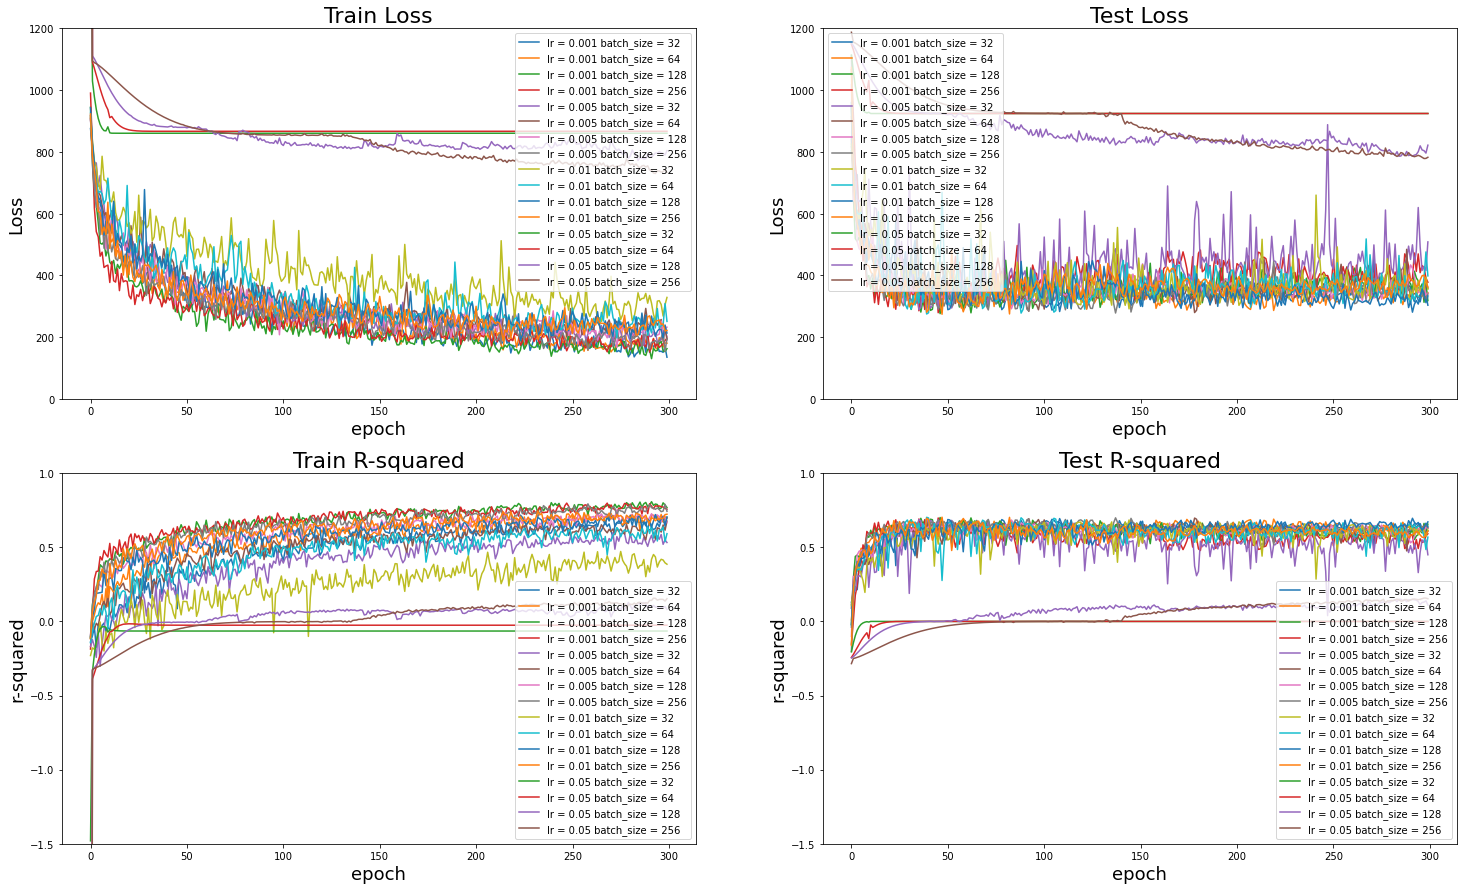

<Figure size 1800x1080 with 0 Axes>

In [35]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1200])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1200])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-1.5,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-1.5,1])

plt.show()

In [26]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.701655625667611
0.6979345234689495
0.7682827421799071
0.7568118413162505
0.5322023401226066
0.6766185695078247
0.6670842938271305
0.7427896437832331
0.3858653002168745
0.5918783861927543
0.7043793575864876
0.7228118757310298
-0.06490232836607002
-0.025599924129800316
0.08118623672233864
0.15341714840855344
___________________

0.6714290834150789
0.6270943364013168
0.655191711024591
0.5909435727166295
0.4496346659066973
0.6115300917274625
0.6291990401707612
0.6323663723084814
0.6151042406849798
0.5686182876296662
0.6387914651037376
0.6076098911688937
-7.432546963603848e-05
-7.398080648557404e-05
0.11087107943096097
0.15330626319091767
___________________

135.4292579749962
180.73083442296738
163.17312202453613
197.26849517822265
201.79668233301732
192.18263283754007
232.81566467285157
195.31894226074218
328.98323608992933
251.35452857384314
213.70342674255372
222.1526306152344
860.5925477263215
866.9175978440505
804.0363662719726
734.0385040283203
___________________

303.735412597656

### 2 best models

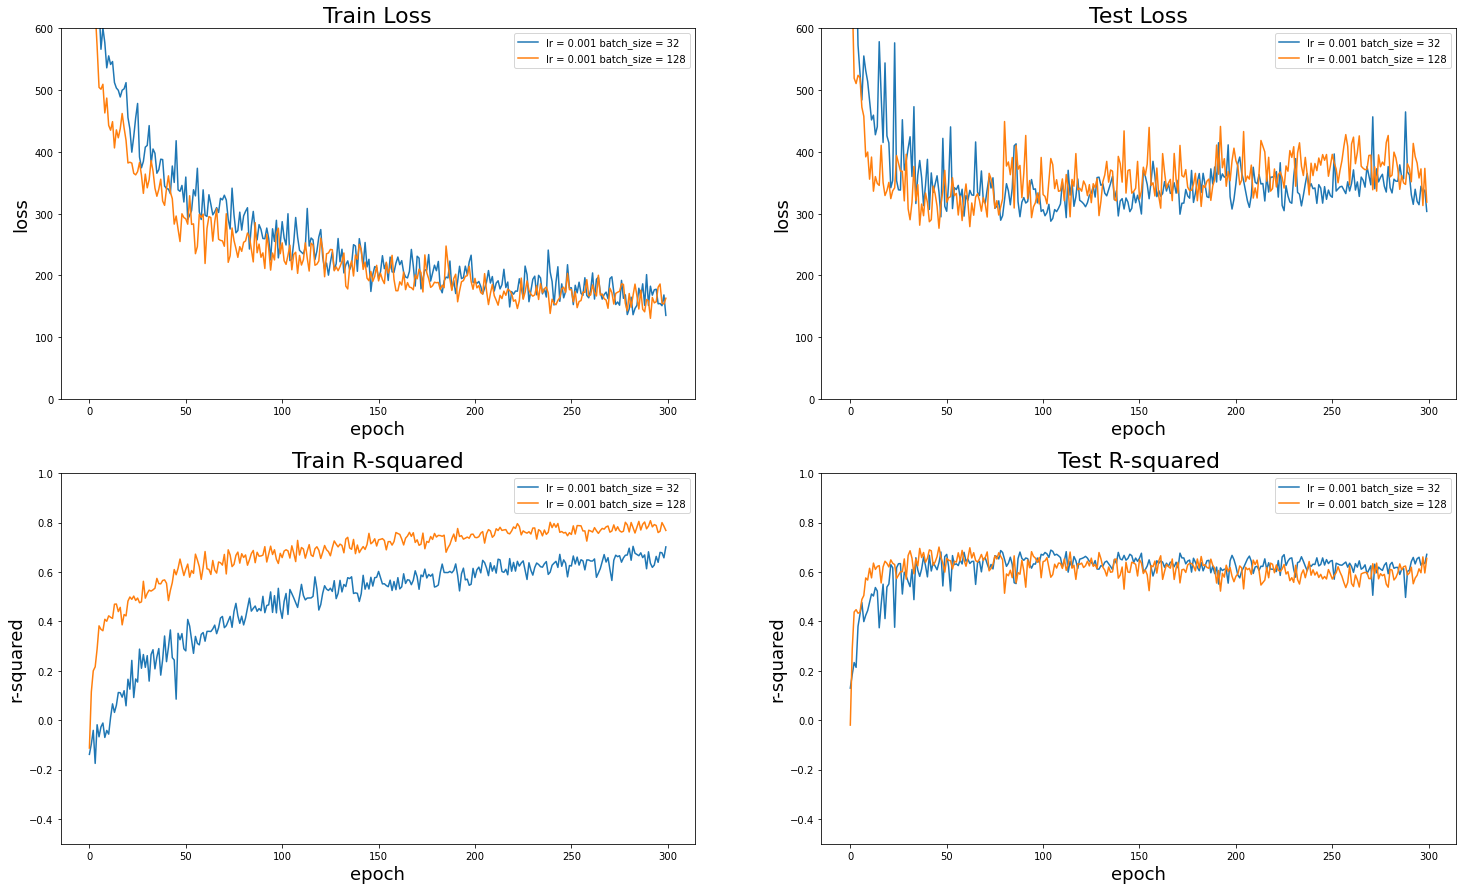

<Figure size 432x288 with 0 Axes>

In [36]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="lr = 0.001 batch_size = 32")
ax1.plot(train_losses_all[2],label="lr = 0.001 batch_size = 128")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 600])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[0],label="lr = 0.001 batch_size = 32")
ax2.plot(test_losses_all[2],label="lr = 0.001 batch_size = 128")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 600])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[0],label="lr = 0.001 batch_size = 32")
ax3.plot(train_accs_all[2],label="lr = 0.001 batch_size = 128")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[0],label="lr = 0.001 batch_size = 32")
ax4.plot(test_accs_all[2],label="lr = 0.001 batch_size = 128")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,1])
plt.show()

## 4.2. Training

In [31]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=704, shuffle=False)

In [32]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1000
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/caco_pubchem_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 877.2274545322765, Accuracy: -0.17476734383150097
Test Avg. loss: 1149.4384765625, Accuracy: -0.11002223963640523
################## EPOCH 2 ##################
Train Avg. loss: 772.9554800553756, Accuracy: -0.09417433600351131
Test Avg. loss: 1244.684814453125, Accuracy: -0.20200251397197788
################## EPOCH 3 ##################
Train Avg. loss: 720.1526320197365, Accuracy: -0.08193590610243452
Test Avg. loss: 923.4874267578125, Accuracy: 0.10818041798242728
################## EPOCH 4 ##################
Train Avg. loss: 669.206317988309, Accuracy: -0.07646918998027238
Test Avg. loss: 850.5630493164062, Accuracy: 0.17860417397275952
################## EPOCH 5 ##################
Train Avg. loss: 627.0343310616233, Accuracy: -0.1517009886150356
Test Avg. loss: 820.6069946289062, Accuracy: 0.20753300312512002
################## EPOCH 6 ##################
Train Avg. loss: 592.4149612079967, Accuracy: -0.06279630478901523

Train Avg. loss: 371.89449310302734, Accuracy: 0.27048411522825777
Test Avg. loss: 537.6499633789062, Accuracy: 0.4807869967168197
################## EPOCH 49 ##################
Train Avg. loss: 358.33569609035146, Accuracy: 0.3435940723608931
Test Avg. loss: 592.6838989257812, Accuracy: 0.4276401820256124
################## EPOCH 50 ##################
Train Avg. loss: 361.14493148977107, Accuracy: 0.2806757319190763
Test Avg. loss: 650.4794921875, Accuracy: 0.37182647993935225
################## EPOCH 51 ##################
Train Avg. loss: 390.0492477416992, Accuracy: 0.2676439712890708
Test Avg. loss: 549.30517578125, Accuracy: 0.46953146977837124
################## EPOCH 52 ##################
Train Avg. loss: 341.19112179496074, Accuracy: 0.2517121218178389
Test Avg. loss: 571.143798828125, Accuracy: 0.44844165367072053
################## EPOCH 53 ##################
Train Avg. loss: 340.5182984525507, Accuracy: 0.33414485566636226
Test Avg. loss: 571.2086181640625, Accuracy: 0.44837

Train Avg. loss: 289.18657497926193, Accuracy: 0.4559146966955732
Test Avg. loss: 582.0022583007812, Accuracy: 0.4379556044587236
################## EPOCH 96 ##################
Train Avg. loss: 290.51230777393687, Accuracy: 0.4015252881639469
Test Avg. loss: 598.5239868164062, Accuracy: 0.42200041723928494
################## EPOCH 97 ##################
Train Avg. loss: 255.6739310351285, Accuracy: 0.4739607920324986
Test Avg. loss: 573.2636108398438, Accuracy: 0.4463945443929581
################## EPOCH 98 ##################
Train Avg. loss: 262.50863638791174, Accuracy: 0.3958231739195314
Test Avg. loss: 582.3528442382812, Accuracy: 0.4376170314797907
################## EPOCH 99 ##################
Train Avg. loss: 291.0053080645475, Accuracy: 0.471741190015568
Test Avg. loss: 551.3494873046875, Accuracy: 0.4675572178851818
################## EPOCH 100 ##################
Train Avg. loss: 255.6772555437955, Accuracy: 0.3826702357499666
Test Avg. loss: 506.7112731933594, Accuracy: 0.5106

Train Avg. loss: 239.84644876826894, Accuracy: 0.46243429171301037
Test Avg. loss: 526.1885986328125, Accuracy: 0.49185531343012523
################## EPOCH 143 ##################
Train Avg. loss: 229.0715436068448, Accuracy: 0.5428704253523512
Test Avg. loss: 554.0584106445312, Accuracy: 0.4649411691830112
################## EPOCH 144 ##################
Train Avg. loss: 273.7735456553373, Accuracy: 0.4516283263747052
Test Avg. loss: 550.3054809570312, Accuracy: 0.4685653783651502
################## EPOCH 145 ##################
Train Avg. loss: 257.237753347917, Accuracy: 0.4551914083139519
Test Avg. loss: 556.759765625, Accuracy: 0.4623324257134219
################## EPOCH 146 ##################
Train Avg. loss: 237.1245199767026, Accuracy: 0.5300713010981776
Test Avg. loss: 532.144287109375, Accuracy: 0.48610382657392637
################## EPOCH 147 ##################
Train Avg. loss: 201.71127020228994, Accuracy: 0.5872051624562684
Test Avg. loss: 469.503662109375, Accuracy: 0.54659

Train Avg. loss: 213.7211031480269, Accuracy: 0.5264109015354435
Test Avg. loss: 539.0218505859375, Accuracy: 0.4794621180794236
################## EPOCH 190 ##################
Train Avg. loss: 197.57771409641612, Accuracy: 0.5968041840668759
Test Avg. loss: 521.5872802734375, Accuracy: 0.4962988445989591
################## EPOCH 191 ##################
Train Avg. loss: 229.51229372891513, Accuracy: 0.5020316986384356
Test Avg. loss: 520.77197265625, Accuracy: 0.4970862321921682
################## EPOCH 192 ##################
Train Avg. loss: 193.583289493214, Accuracy: 0.58334135620559
Test Avg. loss: 528.2237548828125, Accuracy: 0.4898899378839633
################## EPOCH 193 ##################
Train Avg. loss: 201.08866591887042, Accuracy: 0.6015552948613176
Test Avg. loss: 538.7960815429688, Accuracy: 0.47968015346317994
################## EPOCH 194 ##################
Train Avg. loss: 221.9657245982777, Accuracy: 0.5799036940171974
Test Avg. loss: 562.3135986328125, Accuracy: 0.4569

Train Avg. loss: 172.8053934140639, Accuracy: 0.6337929722998443
Test Avg. loss: 529.6008911132812, Accuracy: 0.48856000343261075
################## EPOCH 237 ##################
Train Avg. loss: 172.5601977001537, Accuracy: 0.6228711138250119
Test Avg. loss: 563.5916137695312, Accuracy: 0.45573482896829876
################## EPOCH 238 ##################
Train Avg. loss: 160.6166351708499, Accuracy: 0.63871817575391
Test Avg. loss: 558.0642700195312, Accuracy: 0.4610726879402218
################## EPOCH 239 ##################
Train Avg. loss: 174.44489015232432, Accuracy: 0.639331016114419
Test Avg. loss: 557.2530517578125, Accuracy: 0.46185611509102187
################## EPOCH 240 ##################
Train Avg. loss: 183.52742702310735, Accuracy: 0.574474854016817
Test Avg. loss: 534.7544555664062, Accuracy: 0.48358314242523026
################## EPOCH 241 ##################
Train Avg. loss: 178.0811626260931, Accuracy: 0.5973437973013893
Test Avg. loss: 521.36474609375, Accuracy: 0.496

Train Avg. loss: 179.1125759644942, Accuracy: 0.6297709362250484
Test Avg. loss: 589.0718383789062, Accuracy: 0.43112842902359505
################## EPOCH 284 ##################
Train Avg. loss: 190.8687159798362, Accuracy: 0.5864446018312802
Test Avg. loss: 588.00244140625, Accuracy: 0.43216115741908645
################## EPOCH 285 ##################
Train Avg. loss: 154.63332562013105, Accuracy: 0.6446024717693821
Test Avg. loss: 622.8831176757812, Accuracy: 0.398476546509827
################## EPOCH 286 ##################
Train Avg. loss: 202.45222429795697, Accuracy: 0.6261004314219745
Test Avg. loss: 573.1038208007812, Accuracy: 0.44654888141787874
################## EPOCH 287 ##################
Train Avg. loss: 165.59204099395058, Accuracy: 0.6493956560207782
Test Avg. loss: 566.953125, Accuracy: 0.45248862823225455
################## EPOCH 288 ##################
Train Avg. loss: 206.31344548138705, Accuracy: 0.6237090911237566
Test Avg. loss: 612.1135864257812, Accuracy: 0.40887

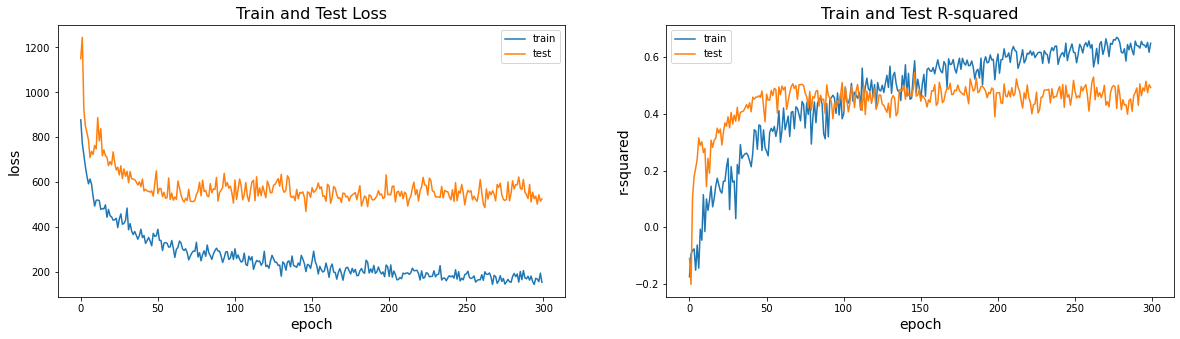

<Figure size 1440x360 with 0 Axes>

In [33]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.legend()

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.legend()
plt.show()

In [34]:
model = FCNN()
model.load_state_dict(torch.load('../../models/caco_pubchem_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 10.088208
MSE: 469.5036
RMSE: 21.668032
R2 Square 0.5465964353762538 

